# Normative model 


In this script we perform the normative model on the ABIDE dataset where TC are the train set and ASD the test set. We included 10% of the TC in the test set. We used the Destrieux atlas for the ROIs. The deviation scores and plots are saved in the results folder. 

## Import all packages

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import pickle
import chardet
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.image as mpimg
from scipy.stats import linregress
import random as rd 
from random import uniform, random, choice, sample
from sklearn.model_selection import train_test_split
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
import pcntoolkit.dataio.fileio as fileio
from nilearn import plotting
import nibabel as nib
from nilearn import datasets


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Define variables needed for the model

### Specify algorithm

In [2]:
algo = 'blr'
optimizer = 'powell'
seed = 0

### Set directories

In [3]:
#Set to correct working directory
os.chdir('/Volumes/methlab/Students/Jente/Scripts_ASD_analysis_final/python_scripts/ASD_model')

# where the analysis takes place
root_dir = os.path.dirname(os.getcwd())

folder_dir = os.path.join(root_dir, 'ASD_model')

# where the raw data are stored
data_dir = os.path.join(root_dir, 'data')

# where the results are saved
result_dir = os.path.join(folder_dir, 'results')

#Save brain plots
brainplot_dir = os.path.join(result_dir, 'Brainmaps')
statsplot_dir = os.path.join(brainplot_dir, 'Statplots')

# when testing for control group
out_dir = os.path.join(os.path.join(result_dir, algo), optimizer)

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'outputs'), exist_ok=True)

os.makedirs(brainplot_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'Brainmaps'), exist_ok=True)

os.makedirs(statsplot_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'Statplots'), exist_ok=True)


## Load data

We prepared in R one big csv file with all data. Bad quality data is already excluded.

In [4]:
all_data = pd.read_csv('Data/Data_normative_Destrieux.txt')

The site_IDs are called differently for ABIDE2 but this can cause problems in the model. Therefore we have to rename these to the short site IDs. 

In [5]:
for i, row in all_data.iterrows():
    
    if row[1].find('ABIDE')!=-1 and row[1].find('_')!=-1 and row[1].find('-')!=-1:
        
        all_data['SITE_ID'][i] = (all_data['SITE_ID'][i].split('-'))[1].split('_')[0]
        
        
    elif row[1].find('ABIDE')!=-1 and row[1].find('_')!=-1 and row[1].find('-')==-1:
        
        all_data['SITE_ID'][i] = all_data['SITE_ID'][i][1].split('_')[0]
        
    elif row[1].find('ABIDE')!=-1 and row[1].find('-')!=-1 and row[1].find('_')==-1:
        
        all_data['SITE_ID'][i] = all_data['SITE_ID'][i][1].split('-')[1]
        


/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/1661823978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['SITE_ID'][i] = (all_data['SITE_ID'][i].split('-'))[1].split('_')[0]


In [6]:
# Create a list of all the ROIs 
roi_ids = np.array(all_data.columns[6:-3])

# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(inplace=True)


## Split in train and test

We use a split based on diagnosis. ASD will be the test set and TC will be the training set. However, we will also add 10% of the TC to the training set

In [7]:
#First split into ASD and TC
all_data_ASD = all_data[(all_data.DX_GROUP==1)]
all_data_TC = all_data[(all_data.DX_GROUP==2)]

# Split into covariates and brain
df_brainfeatures_ASD = all_data_ASD[roi_ids]
df_brainfeatures_TC = all_data_TC[roi_ids]

df_covariates_ASD = all_data_ASD[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]
df_covariates_TC = all_data_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]

#Also make a dataframe with both test and train but only features of covariates
df_brainfeatures = all_data[roi_ids]
df_covariates = all_data[['AGE_AT_SCAN', 'FIQ', 'SITE_ID','meanEULER']]


# Then split the TC set in train and test with 10% in test. 
train_covariates_TC, test_covariates_TC,train_brainfeatures_TC, test_brainfeatures_TC = train_test_split(df_covariates_TC, df_brainfeatures_TC, test_size=0.1,random_state=43)

# Rename columns so it matches the normative model code
df_brainfeatures_train = train_brainfeatures_TC
df_covariates_train = train_covariates_TC

#Add the randomly selected TC to the ASD to create the test dataset
df_brainfeatures_test = pd.concat([df_brainfeatures_ASD,test_brainfeatures_TC])
df_covariates_test = pd.concat([df_covariates_ASD, test_covariates_TC])

df_covariates_testTC = test_covariates_TC
df_brainfeatures_testTC = test_brainfeatures_TC

## Plot both train and test to see if the overlap is good in variables


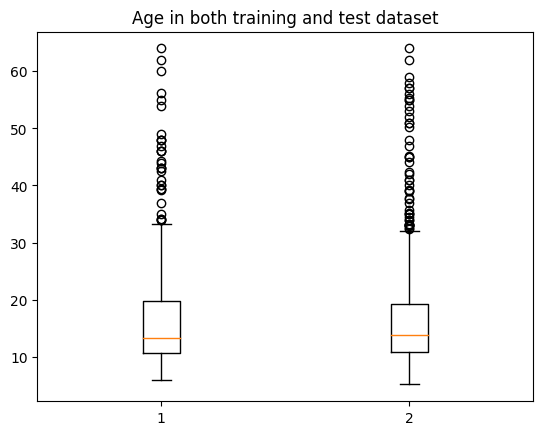

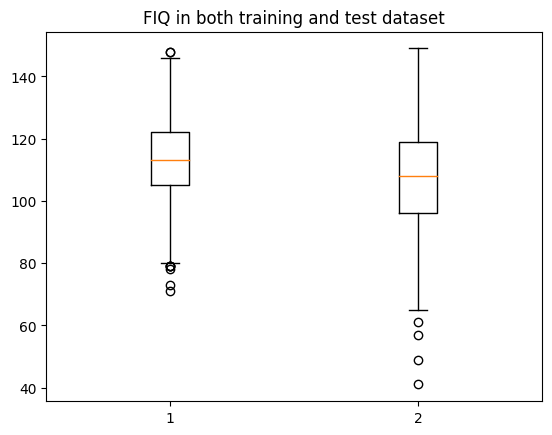

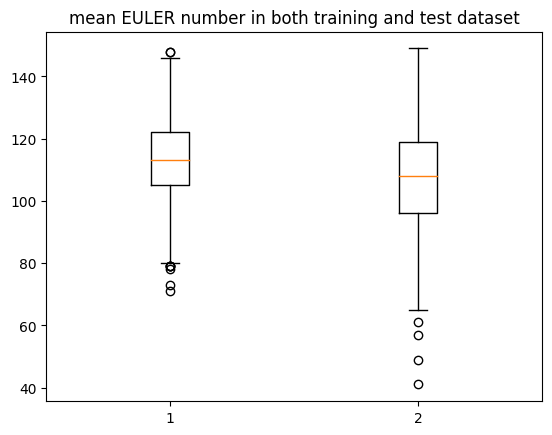

In [8]:
plot_data_age = [df_covariates_train['AGE_AT_SCAN'], df_covariates_test['AGE_AT_SCAN']]
plt.boxplot(plot_data_age)
plt.title('Age in both training and test dataset')
plt.show()

plot_data_FIQ = [df_covariates_train['FIQ'], df_covariates_test['FIQ']]
plt.boxplot(plot_data_FIQ)
plt.title('FIQ in both training and test dataset')
plt.show()

plot_data_euler = [df_covariates_train['meanEULER'], df_covariates_test['meanEULER']]
plt.boxplot(plot_data_FIQ)
plt.title('mean EULER number in both training and test dataset')
plt.show()


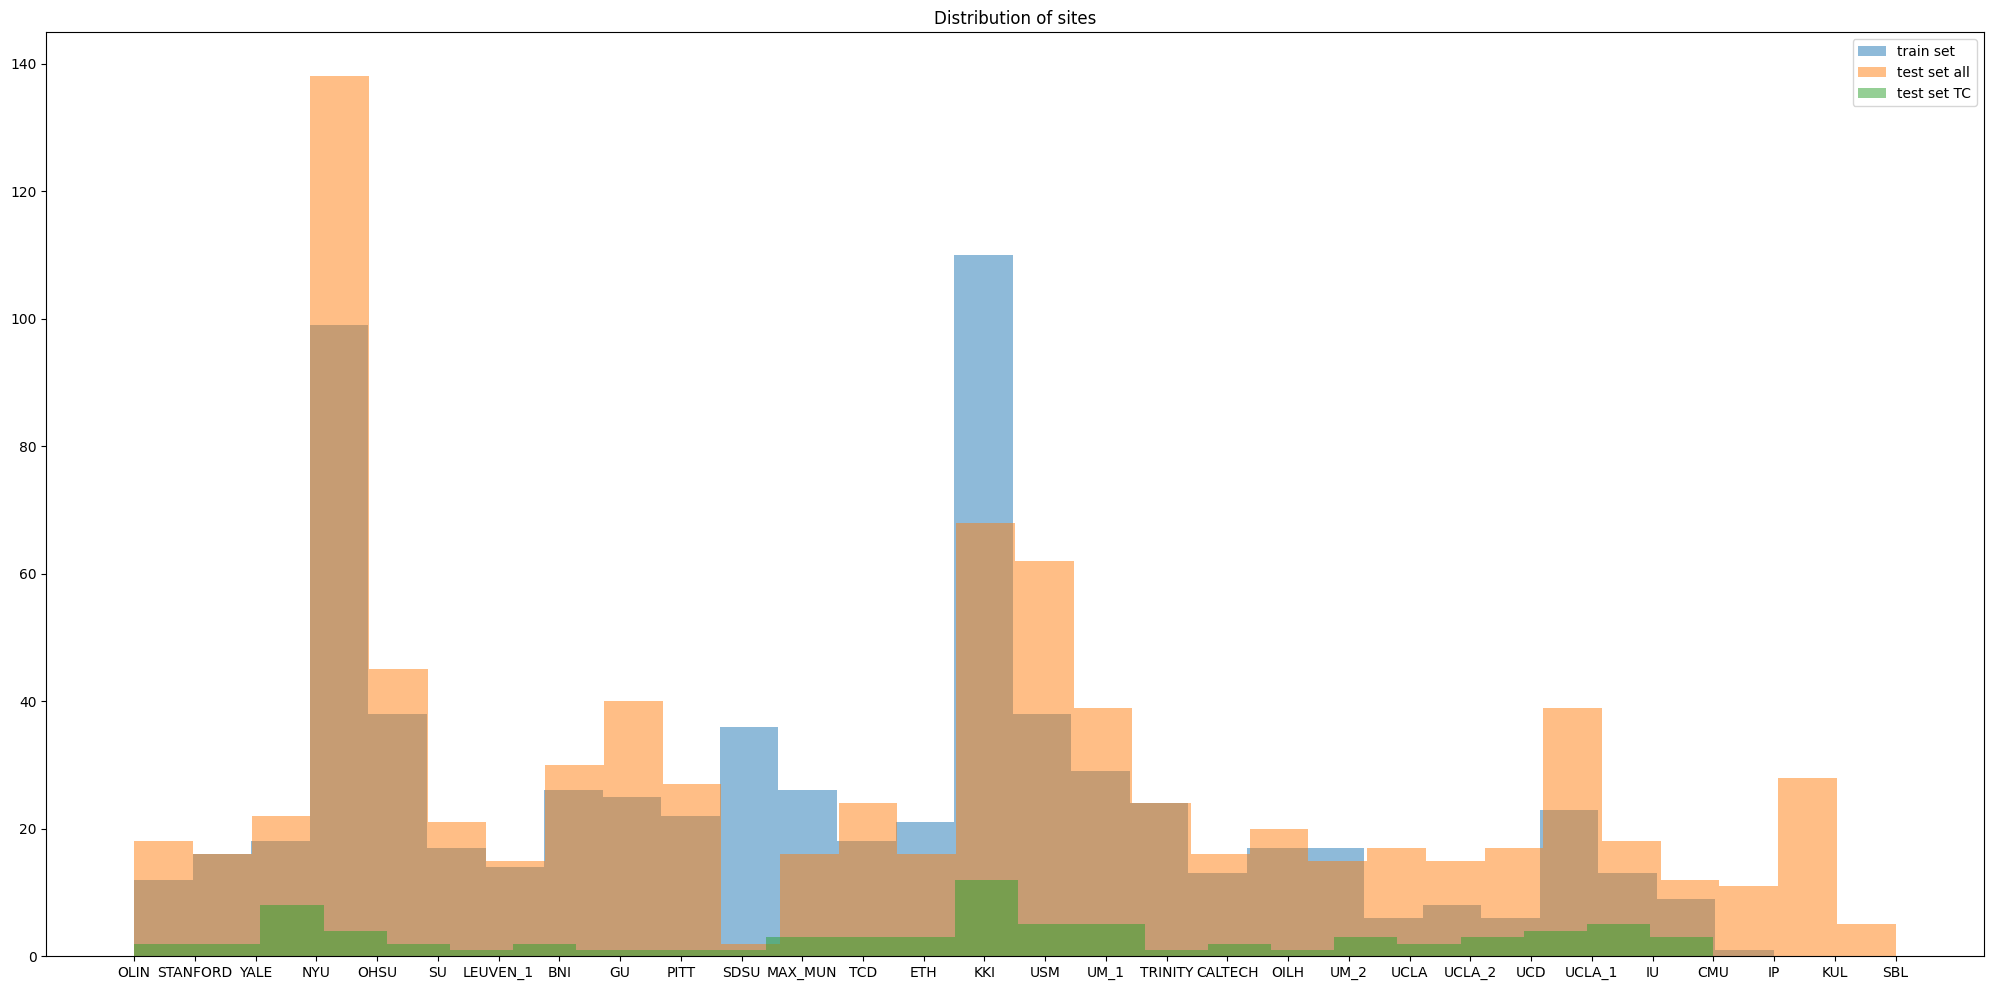

In [9]:
# Plot distribution across sites to see if this is a good split.
plt.rc('figure', figsize=(25, 12))

plt.hist(df_covariates_train['SITE_ID'], alpha=0.5, label='train set',bins=len(np.unique(df_covariates_train['SITE_ID'])))
plt.hist(df_covariates_test['SITE_ID'], alpha=0.5, label = 'test set all', bins=len(np.unique(df_covariates_test['SITE_ID'])))
plt.hist(df_covariates_testTC['SITE_ID'], alpha=0.5, label='test set TC', bins=25)
plt.legend()
plt.title('Distribution of sites')
plt.show()

We see that for 2 sites, there are no participants in the training set. We have to remove these sites.

We see that the train dataset does not contain: KUL and SBL. KUL didn't include any TCs. SBL does have both, however, there is no IQ data available for the TC and therefore these are removed. 



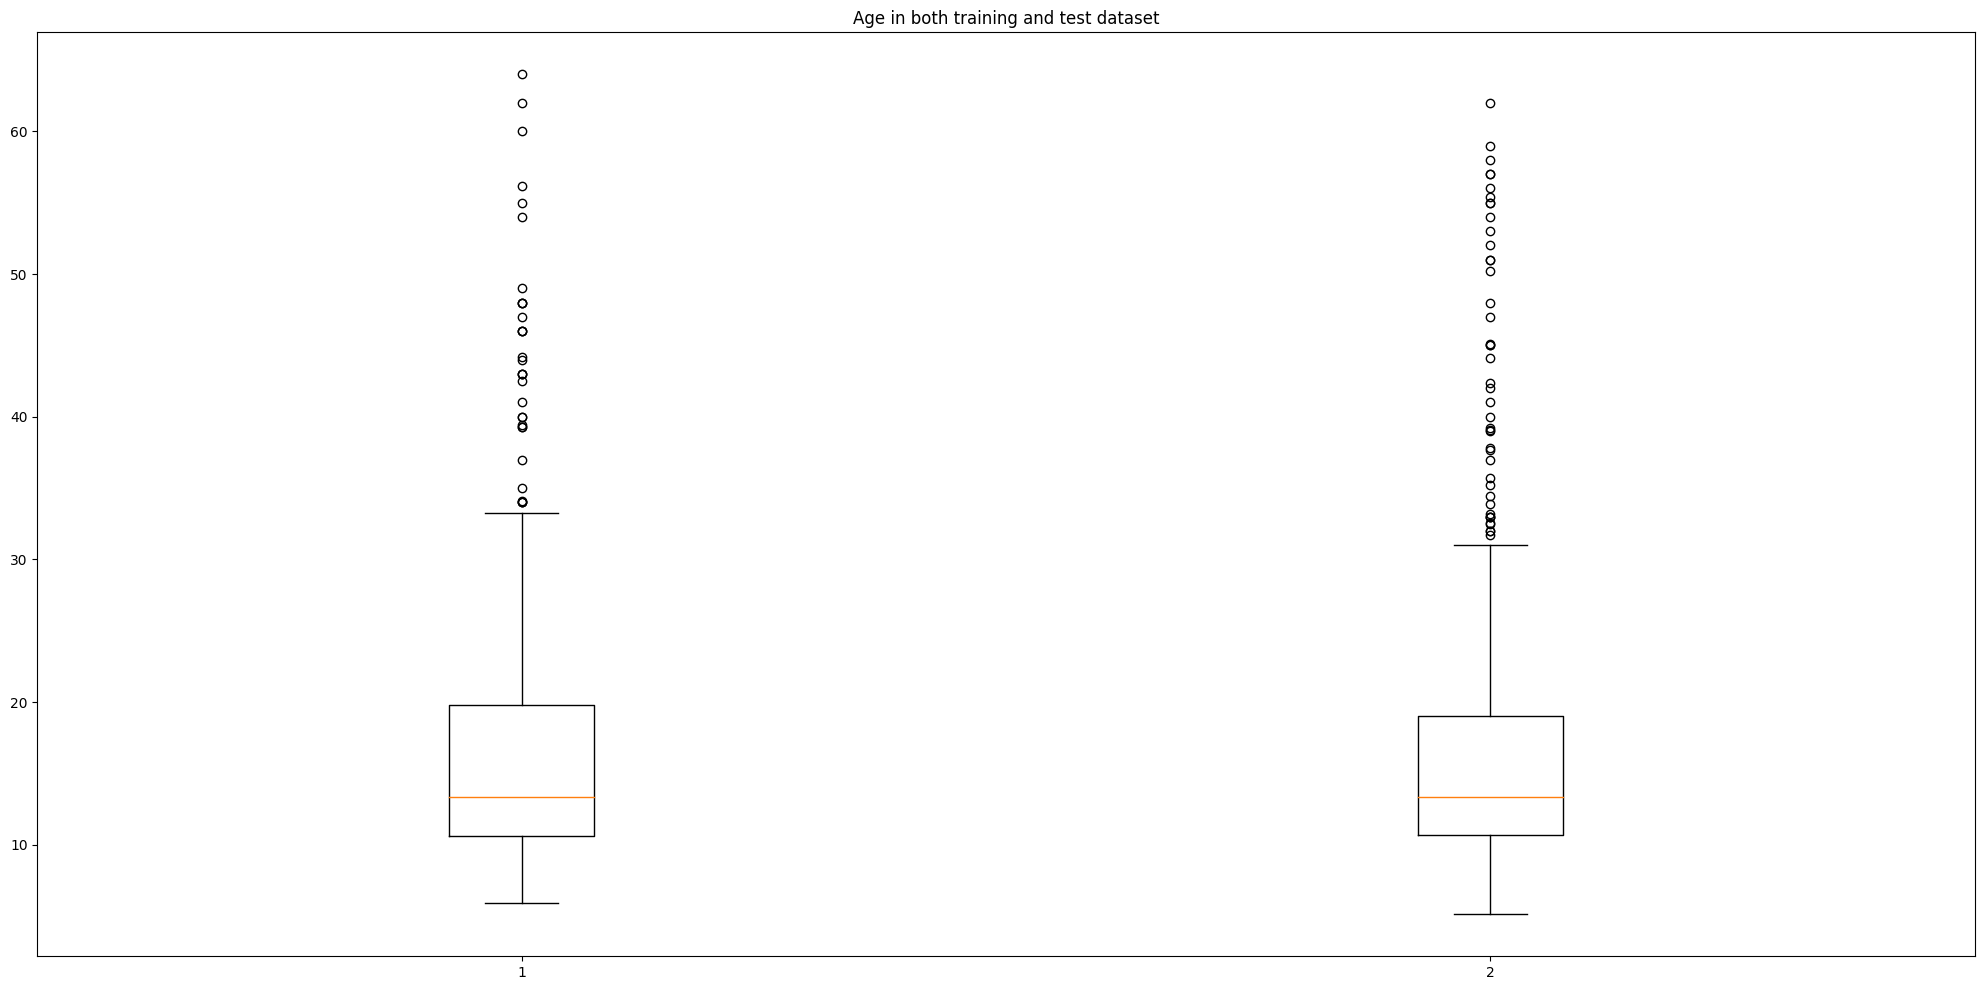

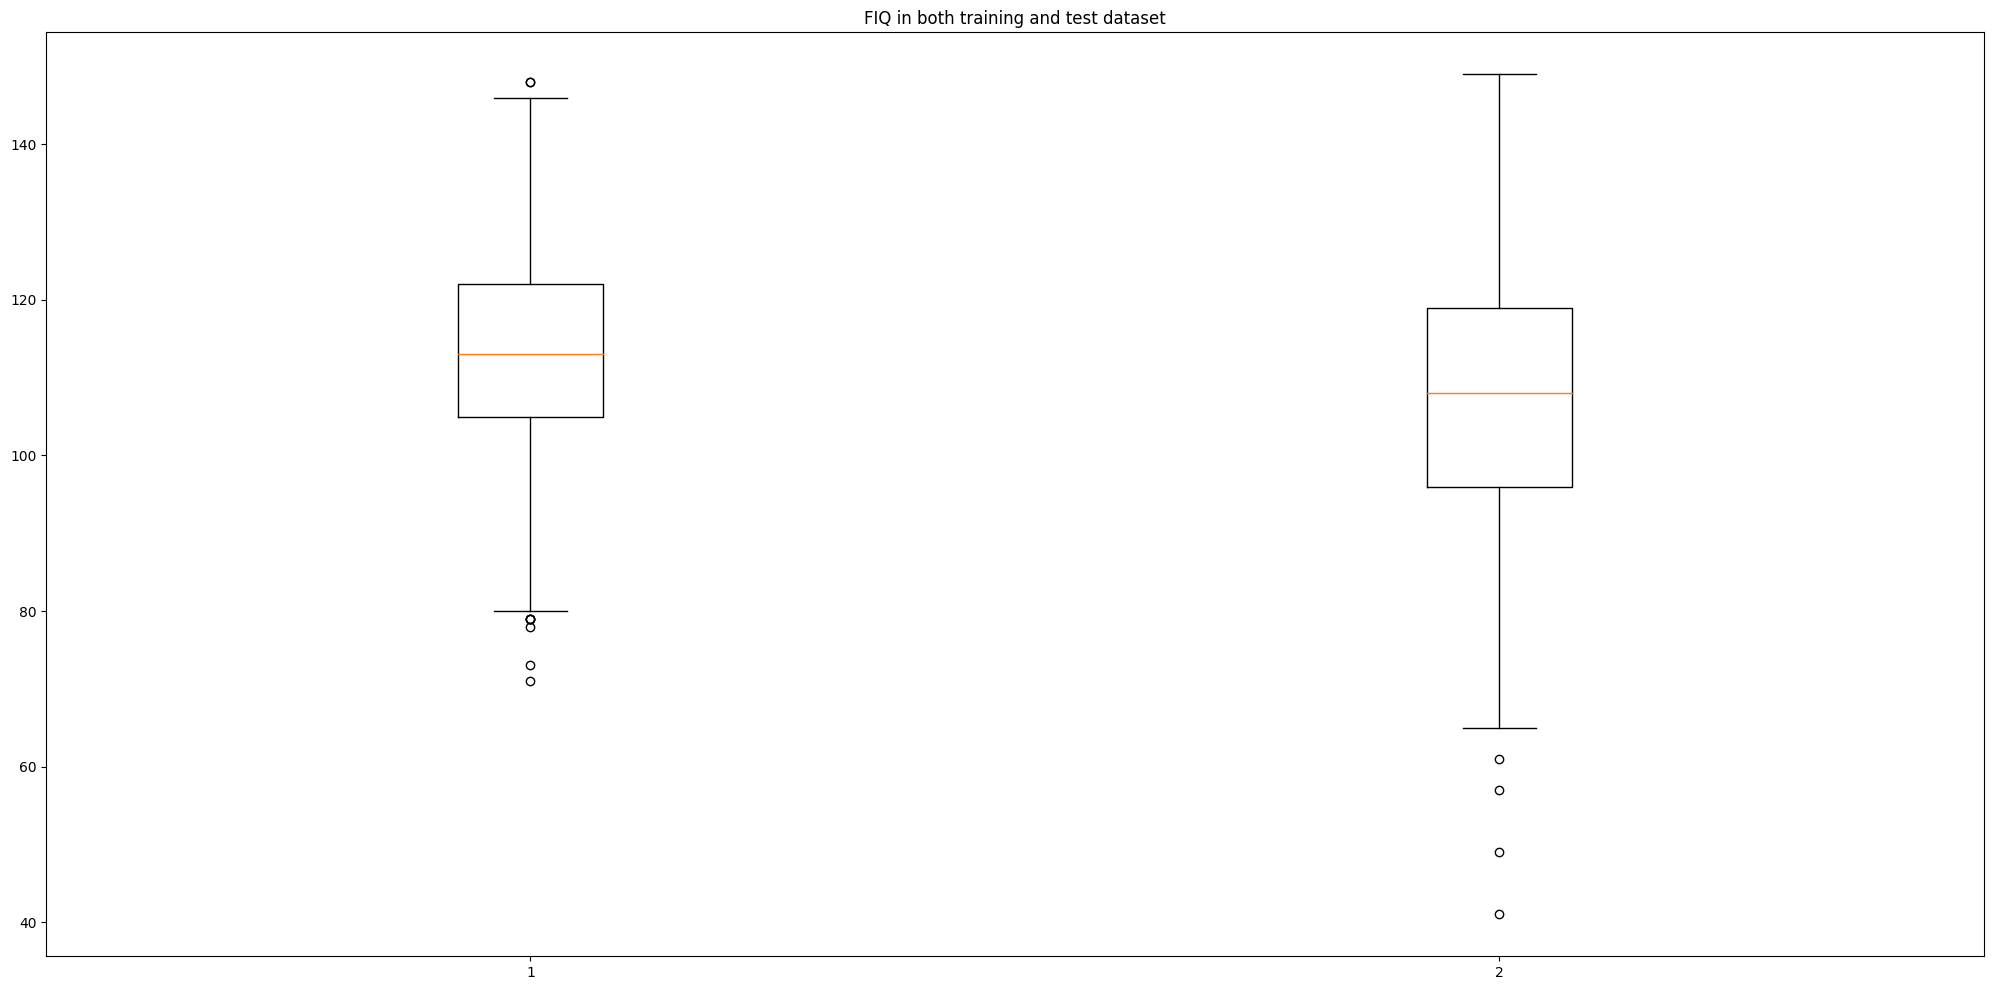

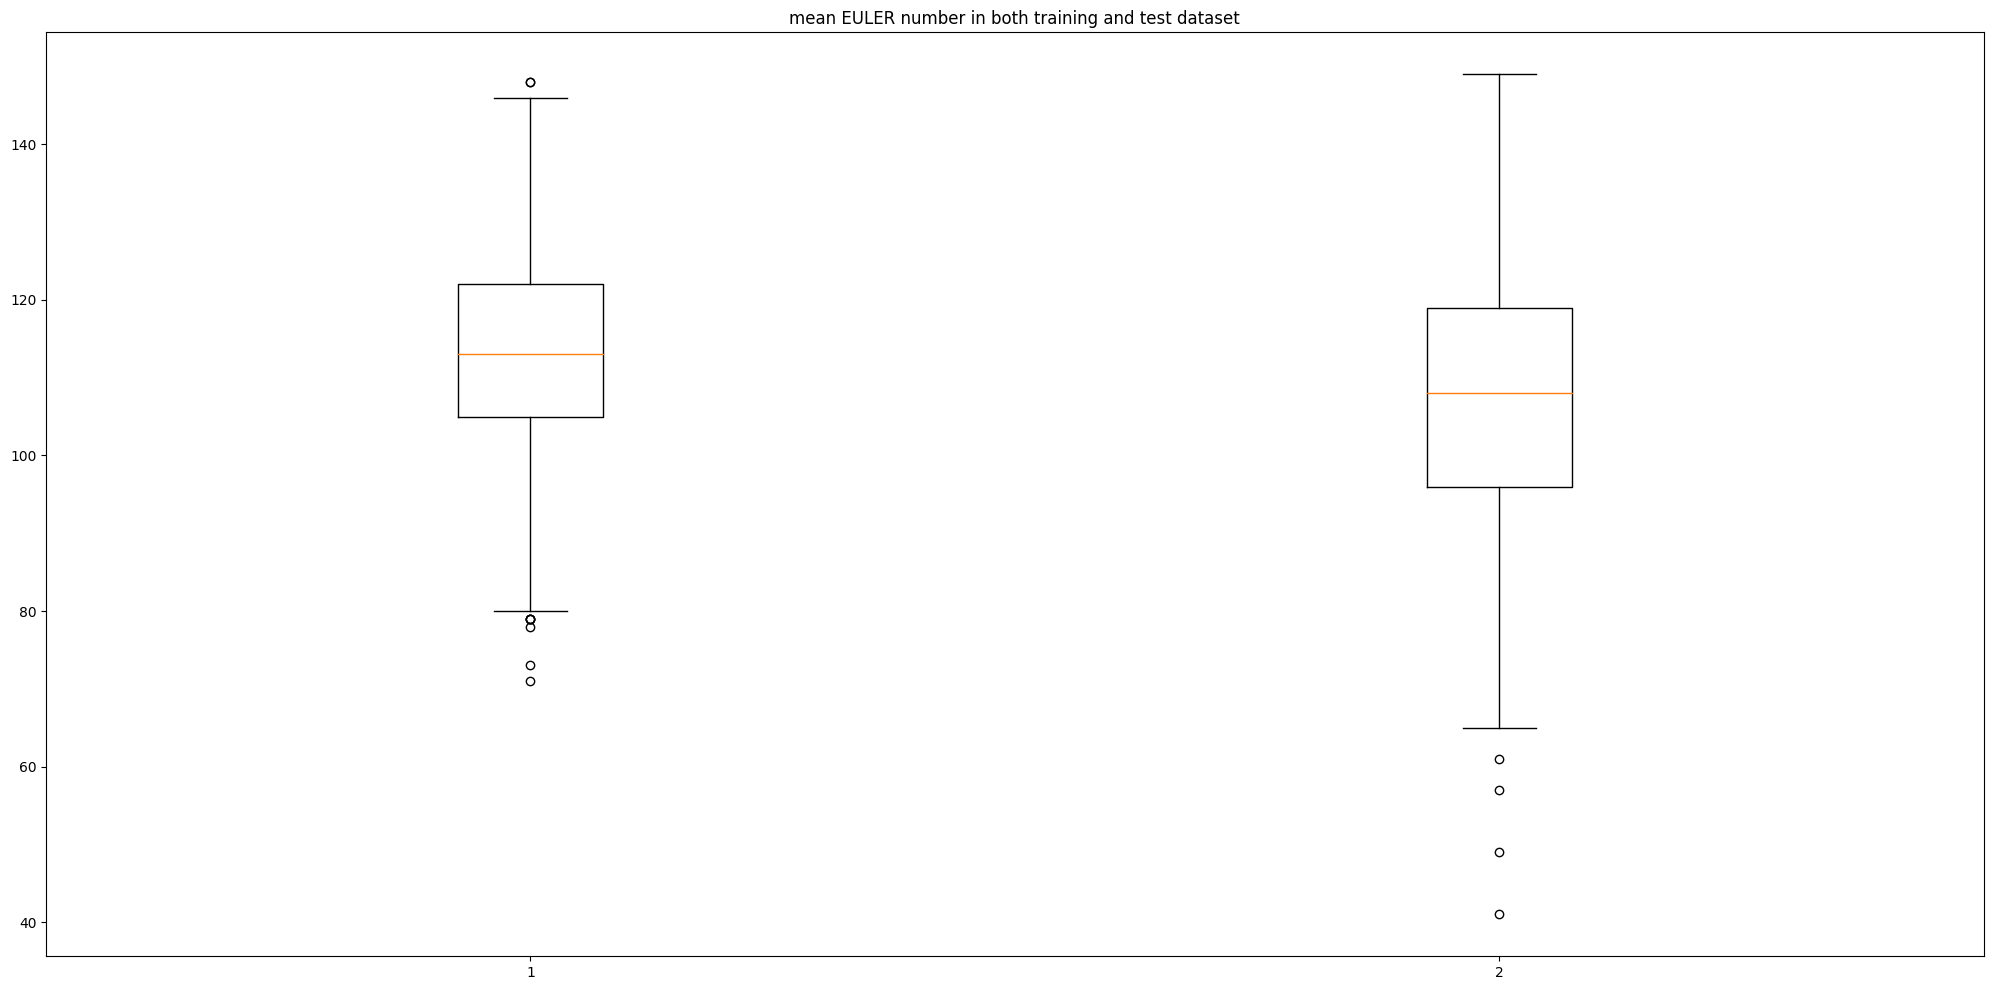

26

In [10]:
# Remove all participants from KUL and SBL

all_data = all_data.drop(all_data[(all_data.SITE_ID == 'KUL') | (all_data.SITE_ID == 'SBL')].index)


#First split into ASD and TC
all_data_ASD = all_data[(all_data.DX_GROUP==1)]
all_data_TC = all_data[(all_data.DX_GROUP==2)]

# Split into covariates and brain
df_brainfeatures_ASD = all_data_ASD[roi_ids]
df_brainfeatures_TC = all_data_TC[roi_ids]

df_covariates_ASD = all_data_ASD[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]
df_covariates_TC = all_data_TC[['SUB_ID','AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']] #We include SUB_ID for now because we want to have this information in later steps. However, remove this after splitting in test and train. 

#Also make a dataframe with both test and train but only features of covariates
df_brainfeatures = all_data[roi_ids]
df_covariates = all_data[['AGE_AT_SCAN', 'FIQ', 'SITE_ID','meanEULER']]


# Split TC set into train and test with 10% in test
train_covariates_TC, test_covariates_TC,train_brainfeatures_TC, test_brainfeatures_TC = train_test_split(df_covariates_TC, df_brainfeatures_TC, test_size=0.1, random_state=43)

#Rename data so it matches normative model code
df_brainfeatures_train = train_brainfeatures_TC
df_covariates_train = train_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]

#Add the randomly selected TC to the ASD to create the test dataset
df_brainfeatures_test = pd.concat([df_brainfeatures_ASD,test_brainfeatures_TC])
df_covariates_test = pd.concat([df_covariates_ASD, test_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]])

df_covariates_testTC = test_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER']]
df_brainfeatures_testTC = test_brainfeatures_TC

#Plots
plot_data_age = [df_covariates_train['AGE_AT_SCAN'], df_covariates_test['AGE_AT_SCAN']]
plt.boxplot(plot_data_age)
plt.title('Age in both training and test dataset')
plt.show()

plot_data_FIQ = [df_covariates_train['FIQ'], df_covariates_test['FIQ']]
plt.boxplot(plot_data_FIQ)
plt.title('FIQ in both training and test dataset')
plt.show()

plot_data_euler = [df_covariates_train['meanEULER'], df_covariates_test['meanEULER']]
plt.boxplot(plot_data_FIQ)
plt.title('mean EULER number in both training and test dataset')
plt.show()


display(len(np.unique(df_covariates_testTC['SITE_ID'])))

In [11]:
# Save the sub IDs for the TC test set

subids_testTC10 = test_covariates_TC.SUB_ID

subids_testTC10.to_csv('/Volumes/methlab/Students/Jente/Scripts_ASD_analysis_final/python_scripts/ASD_model/subids_test_TC10.csv')


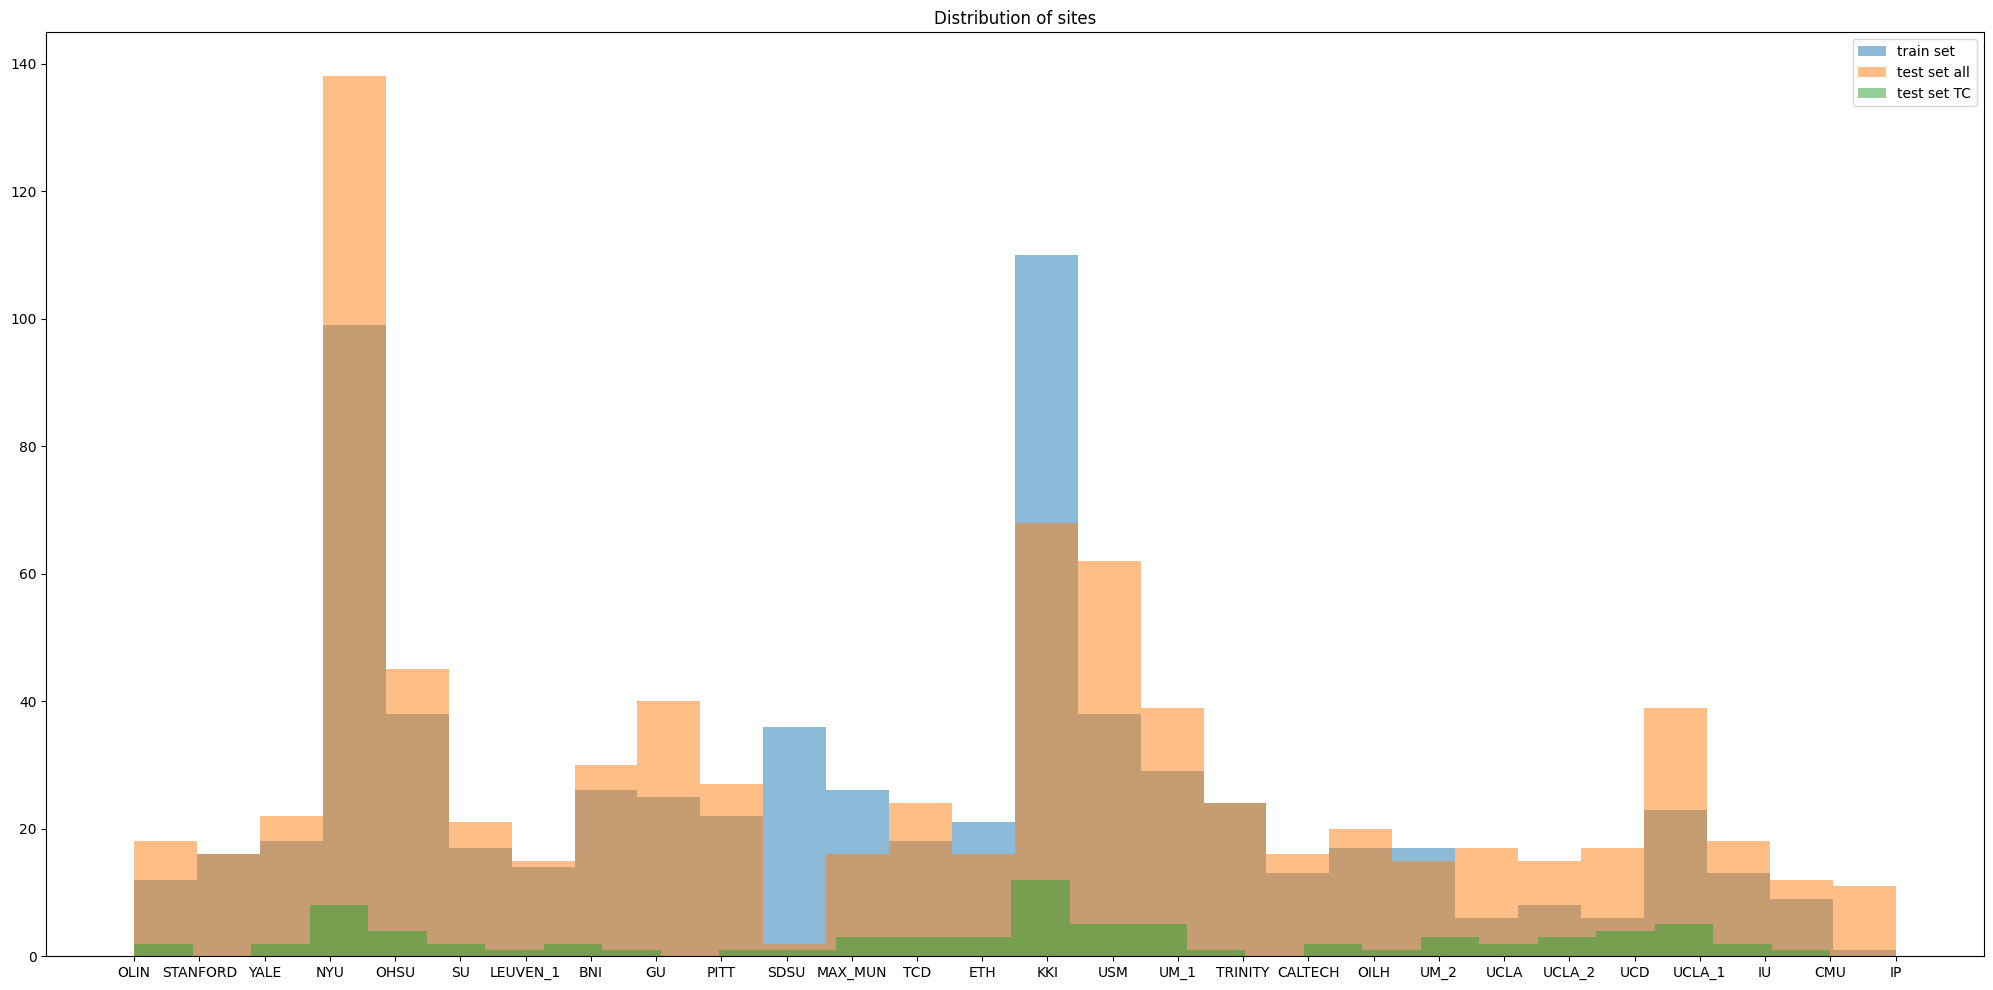

In [12]:
# Again the distribution of the split
plt.rc('figure', figsize=(25, 12))

plt.hist(df_covariates_train['SITE_ID'], alpha=0.5, label='train set',bins=len(np.unique(df_covariates_train['SITE_ID'])))
plt.hist(df_covariates_test['SITE_ID'], alpha=0.5, label = 'test set all', bins=len(np.unique(df_covariates_test['SITE_ID'])))
plt.hist(df_covariates_testTC['SITE_ID'], alpha=0.5, label='test set TC', bins=29)
plt.legend()
plt.title('Distribution of sites')
plt.show()

## 6. Set parameters in a variable

cols_cov: Which covariates used for the model (besides site, this is handeled seperately)

Xmin and xmax are the minimum and maximum age ranges in the data. This age range matches the age range of the participants in this study. 

Basis: bspline: this is in what way we do the non linearity

Site_ids: a list of all sites 

algo: which algorithm used. We use a Bayesian Linear Regression (BLR)

optimizer: We use Powell optimisation

warp: Sets which warping algorithm. We use WarpSinArchinh

out_dir: variable that defines the output directory

nknots: how many knots in the bsplite are used. The default is 5 but we use 3 since this leads to a bit less free result that matches better. Less overfitting.


In [13]:
params = {  'cols_cov' : ['AGE_AT_SCAN', 'FIQ', 'meanEULER'],
            'xmin' : 5,
            'xmax' : 64,
            'basis' : 'bspline',
            'site_ids' : list(all_data.SITE_ID.unique()),
            'algo' : algo,
            'optimizer' : optimizer,  
            'warp' : 'WarpSinArcsinh',
            'out_dir' : out_dir, 
            'nknots' : 3 #Default is 5
         }

suffix = 'estimate'



## 8. Fit normative model

In [14]:
for idp_num, idp in enumerate(roi_ids): # loop through all ROIs
    
    # Set output dir for the current ROI
    idp_dir = os.path.join(params['out_dir'], idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    #Extract the response variables corresponding to the current ROI for training and test set
    y_tr = df_brainfeatures_train[idp].to_numpy()
    y_te = df_brainfeatures_test[idp].to_numpy()
    y_te_TC = df_brainfeatures_testTC[idp].to_numpy()
    
    
    #Write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    resp_file_te_TC = os.path.join(idp_dir,'resp_te_TC.txt')
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
    np.savetxt(resp_file_te_TC, y_te_TC)
    
    #Configure the design matrix
    X_tr = create_design_matrix(df_covariates_train[params['cols_cov']],
                                site_ids = df_covariates_train['SITE_ID'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    X_te = create_design_matrix(df_covariates_test[params['cols_cov']],
                                site_ids = df_covariates_test['SITE_ID'], 
                                all_sites=params['site_ids'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    X_te_TC = create_design_matrix(df_covariates_testTC[params['cols_cov']],
                                site_ids = df_covariates_testTC['SITE_ID'], 
                                all_sites=params['site_ids'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    #Configure and save the design matrix of the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    cov_file_te_TC = os.path.join(idp_dir, 'cov_bspline_te_TC.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)
    np.savetxt(cov_file_te_TC, X_te_TC)

    
    #Estimate model
    estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, testcov = cov_file_te,
             alg=params['algo'], optimizer = params['optimizer'], savemodel = True,
             warp = params['warp'], warp_reparam=True, outputsuffix = suffix)

    #Estimate with only TC as test to see how the model performs outside of diagnosis
    yhat_te_TC, s2_te_TC, Z_TC = predict(cov_file_te_TC,
                                         alg='blr',
                                         respfile = resp_file_te_TC,
                                         model_path = os.path.join(idp_dir, 'Models'),
                                         warp = params['warp'], warp_reparam=True)
    
    
    #Configure and save the estimate values
    yhat_te_TC_file = os.path.join(idp_dir, 'yhat_te_TC.txt')
    s2_te_TC_file = os.path.join(idp_dir, 's2_te_TC.txt')
    Z_TC_file = os.path.join(idp_dir, 'Z_TC.txt')
    np.savetxt(yhat_te_TC_file, yhat_te_TC)
    np.savetxt(s2_te_TC_file, s2_te_TC)
    np.savetxt(Z_TC_file, Z_TC)


Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_analysis_final/python_scripts/ASD_model/results/blr/powell/lh_G_and_S_frontomargin_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -130.140735
         Iterations: 12
         Function evaluations: 582
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_analysis_final/python_scripts/ASD_model/results/blr/powell/lh_G_and_S_occipital_inf_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -175.086686
         Iterations: 13
         Function evaluations: 635
Saving model meta-da

KeyboardInterrupt: 

## 9. Evaluate model

In [ ]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
blr_metrics = pd.DataFrame(columns=['eid','NLL','EV','MSLL','SMSE','BIC','Rho','pRho'])

for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load predictions and true data
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_' + 'te' + '.txt'))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_' + 'tr' + '.txt'))
    
    #Load model
    with open(os.path.join(idp_dir,'Models','NM_0_0_' + suffix + '.pkl'),'rb') as handle:
        nm = pickle.load(handle)
        
    # Compute error metrics
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W = nm.blr.warp
            
    ## warp predictions
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]

    ## evaluation metrics
    metrics = evaluate(y_te, med_te)

    ## compute MSLL manually
    y_val_w = W.f(y_te, warp_param)
    y_tr_w = W.f(y_tr, warp_param)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL = compute_MSLL(y_val_w, yhat_te, s2_te, y_tr_mean, y_tr_var)

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
        
    n = np.shape(Z)[0]
    m1 = np.mean(Z)
    m2 = sum((Z-m1)**2)
    m3 = sum((Z-m1)**3)
    m4 = sum((Z-m1)**4)
    s1 = np.std(Z)
    skew = n*m3/(n-1)/(n-2)/s1**3
    sdskew = np.sqrt( 6*n*(n-1) / ((n-2)*(n+1)*(n+3)) )
    kurtosis = (n*(n+1)*m4 - 3*m2**2*(n-1)) / ((n-1)*(n-2)*(n-3)*s1**4)
    sdkurtosis = np.sqrt( 4*(n**2-1) * sdskew**2 / ((n-3)*(n+5)) )
    semean = np.sqrt(np.var(Z)/n)
    sesd = s1/np.sqrt(2*(n-1))
        
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
        
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                            MSLL[0], metrics['SMSE'][0], BIC, 
                                            metrics['Rho'][0], metrics['pRho'][0]]

    
#Display and save metrics
display(blr_metrics)
blr_metrics.to_csv(os.path.join(out_dir,'outputs','blr_metrics.csv'))



,eid,NLL,EV,MSLL,SMSE,BIC,Rho,pRho
0,lh_G_and_S_frontomargin_thickness,-130.140735,0.016675,0.062615,0.985559,-234.065737,0.319068,8.678130e-21
1,lh_G_and_S_occipital_inf_thickness,-175.086686,-0.010157,0.025866,1.010363,-323.957639,0.205417,3.771181e-09
2,lh_G_and_S_paracentral_thickness,-214.960024,0.219534,-0.109155,0.784573,-403.704315,0.486478,4.580788e-51
3,lh_G_and_S_subcentral_thickness,-165.500314,-0.122833,0.073583,1.125753,-304.784895,0.120898,5.897006e-04
4,lh_G_and_S_transv_frontopol_thickness,38.833610,0.072611,0.021299,0.934939,103.882953,0.369831,4.731342e-28
...,...,...,...,...,...,...,...,...
145,rh_S_subparietal_thickness,-292.636047,0.154262,-0.057026,0.868775,-559.056361,0.445515,7.845939e-42
146,rh_S_temporal_inf_thickness,-209.578060,-0.250992,0.215845,1.252820,-392.940386,0.131331,1.868363e-04
147,rh_S_temporal_sup_thickness,-435.264141,-0.078565,0.216366,1.079981,-844.312549,0.287601,5.727714e-17
148,rh_S_temporal_transverse_thickness,266.311955,-0.198234,0.113017,1.216709,558.839643,-0.013310,7.065652e-01


Do this same evaluation but for the TC test set alone

In [ ]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
blr_metrics_TC = pd.DataFrame(columns=['eid','NLL','EV','MSLL','SMSE','BIC','Rho','pRho'])

for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load predictions and true data
    yhat_te_TC = load_2d(os.path.join(idp_dir, 'yhat_te_TC' + '.txt'))
    s2_te_TC = load_2d(os.path.join(idp_dir, 's2_te_TC' +'.txt'))
    y_te_TC = load_2d(os.path.join(idp_dir, 'resp_' + 'te_TC' + '.txt'))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_' + 'tr' + '.txt'))
    
    #Load model
    with open(os.path.join(idp_dir,'Models','NM_0_0_' + suffix + '.pkl'),'rb') as handle:
        nm = pickle.load(handle)
        
    # Compute error metrics
    warp_param_TC = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W_TC = nm.blr.warp
            
    ## warp predictions
    med_te_TC = W_TC.warp_predictions(np.squeeze(yhat_te_TC), np.squeeze(s2_te_TC), warp_param_TC)[0]
    med_te_TC = med_te_TC[:, np.newaxis]

    ## evaluation metrics
    metrics_TC = evaluate(y_te_TC, med_te_TC)

    ## compute MSLL manually
    y_val_w = W_TC.f(y_te_TC, warp_param_TC)
    y_tr_w = W_TC.f(y_tr, warp_param_TC)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL_TC = compute_MSLL(y_val_w, yhat_te_TC, s2_te_TC, y_tr_mean, y_tr_var)
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_TC' + '.txt'))

    n_TC = np.shape(Z_TC)[0]
    m1_TC = np.mean(Z_TC)
    m2_TC = sum((Z_TC-m1_TC)**2)
    m3_TC = sum((Z_TC-m1_TC)**3)
    m4_TC = sum((Z_TC-m1_TC)**4)
    s1_TC = np.std(Z_TC)
    skew_TC = n_TC*m3_TC/(n_TC-1)/(n_TC-2)/s1_TC**3
    sdskew_TC = np.sqrt( 6*n_TC*(n_TC-1) / ((n_TC-2)*(n_TC+1)*(n_TC+3)) )
    kurtosis_TC = (n_TC*(n_TC+1)*m4_TC - 3*m2_TC**2*(n_TC-1)) / ((n_TC-1)*(n_TC-2)*(n_TC-3)*s1_TC**4)
    sdkurtosis_TC = np.sqrt( 4*(n_TC**2-1) * sdskew_TC**2 / ((n_TC-3)*(n_TC+5)) )
    semean_TC = np.sqrt(np.var(Z_TC)/n_TC)
    sesd_TC = s1_TC/np.sqrt(2*(n_TC-1))
        
    BIC_TC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
        
    blr_metrics_TC.loc[len(blr_metrics_TC)] = [idp, nm.neg_log_lik, metrics_TC['EXPV'][0], 
                                            MSLL_TC[0], metrics_TC['SMSE'][0], BIC_TC, 
                                            metrics_TC['Rho'][0], metrics_TC['pRho'][0]]

    
#Display and save metrics
display(blr_metrics_TC)
blr_metrics_TC.to_csv(os.path.join(out_dir,'outputs','blr_metrics_TC.csv'))


,eid,NLL,EV,MSLL,SMSE,BIC,Rho,pRho
0,lh_G_and_S_frontomargin_thickness,-130.140735,-0.186145,0.057670,1.195441,-234.065737,0.230004,4.118559e-02
1,lh_G_and_S_occipital_inf_thickness,-175.086686,0.053183,-0.007006,0.959038,-323.957639,0.273055,1.459004e-02
2,lh_G_and_S_paracentral_thickness,-214.960024,0.202435,-0.090136,0.807231,-403.704315,0.466322,1.054785e-05
3,lh_G_and_S_subcentral_thickness,-165.500314,-0.356515,0.192324,1.361872,-304.784895,-0.070481,5.382527e-01
4,lh_G_and_S_transv_frontopol_thickness,38.833610,0.067886,-0.037505,0.978113,103.882953,0.409609,1.485548e-04
...,...,...,...,...,...,...,...,...
145,rh_S_subparietal_thickness,-292.636047,0.418527,-0.273758,0.581659,-559.056361,0.647587,1.785543e-11
146,rh_S_temporal_inf_thickness,-209.578060,-0.340512,0.277356,1.340936,-392.940386,0.060742,5.959836e-01
147,rh_S_temporal_sup_thickness,-435.264141,-0.116610,0.329724,1.126381,-844.312549,0.254923,2.305768e-02
148,rh_S_temporal_transverse_thickness,266.311955,-0.260631,0.182769,1.323796,558.839643,-0.089794,4.324995e-01


Vizualize these metrics

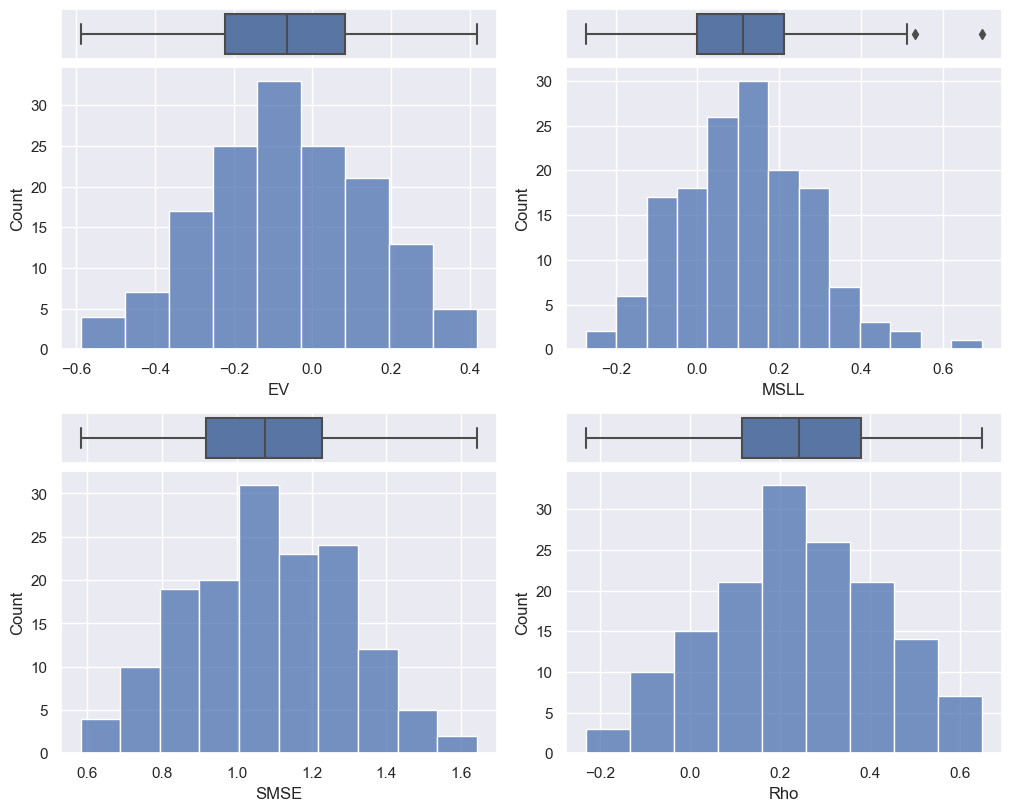

In [ ]:
fig = plt.figure(constrained_layout=True,  figsize=(10,8))

subfigs = fig.subfigures(2, 2)
blr_metrics_TC = pd.read_csv(os.path.join(out_dir,'outputs', 'blr_metrics_TC.csv'))
metrics_TC = ['EV', 'MSLL', 'SMSE', 'Rho']

for outerind, subfig in enumerate(subfigs.flat):
    sns.set(style="darkgrid")
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    (ax_box, ax_hist) = subfig.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # assigning a graph to each ax
    sns.boxplot(data=blr_metrics_TC, x =metrics_TC[outerind], ax=ax_box)
    sns.histplot(data=blr_metrics_TC, x=metrics_TC[outerind], ax=ax_hist)
    
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

plt.savefig(os.path.join(out_dir, 'outputs/metrics_TC.png'))
plt.show()

## 10. Save deviation scores
The deviation scores are output as a text file in separate folders. We want to summarize the deviation scores across all models estimates so we can organize them into a single file, and merge the deviation scores into the original data file.

In [ ]:
#First for training set 
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures_train[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'tr' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'tr' + '.txt')
    
    X = create_design_matrix(df_covariates_train[params['cols_cov']], 
                             site_ids = df_covariates_train['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)

    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'tr')
 



    #Then for test set 
    
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures_test[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'te' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'te' + '.txt')
    X = create_design_matrix(df_covariates_test[params['cols_cov']], 
                             site_ids = df_covariates_test['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)
    
    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'te')

    
#Also for full dataframe so we can evaluate the Z scores for each participant
    
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'all' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'all' + '.txt')
    X = create_design_matrix(df_covariates[params['cols_cov']], 
                             site_ids = df_covariates['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)
    
    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'all')

Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Predict

## 11. Write deviation scores to dataframe including sub ID

For the analysis we need to have the deviation scores for all ROIs in one file for all participants

In [ ]:
#Define sub_ids and reset the index
sub_ids = all_data[["SUB_ID"]]
sub_ids = sub_ids.reset_index()


In [ ]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
Deviation_scores = pd.DataFrame(columns=[roi_ids])


for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load Z scores    
    Z = load_2d(os.path.join(idp_dir,'Z_all.txt'))
    
    
    Deviation_scores[idp] = Z[:,0]

    
Deviation_scores[['SUB_ID']] = sub_ids[['SUB_ID']]


        
#Save deviation scores
Deviation_scores.to_csv(os.path.join(out_dir,'outputs','Deviation_scores.csv'))



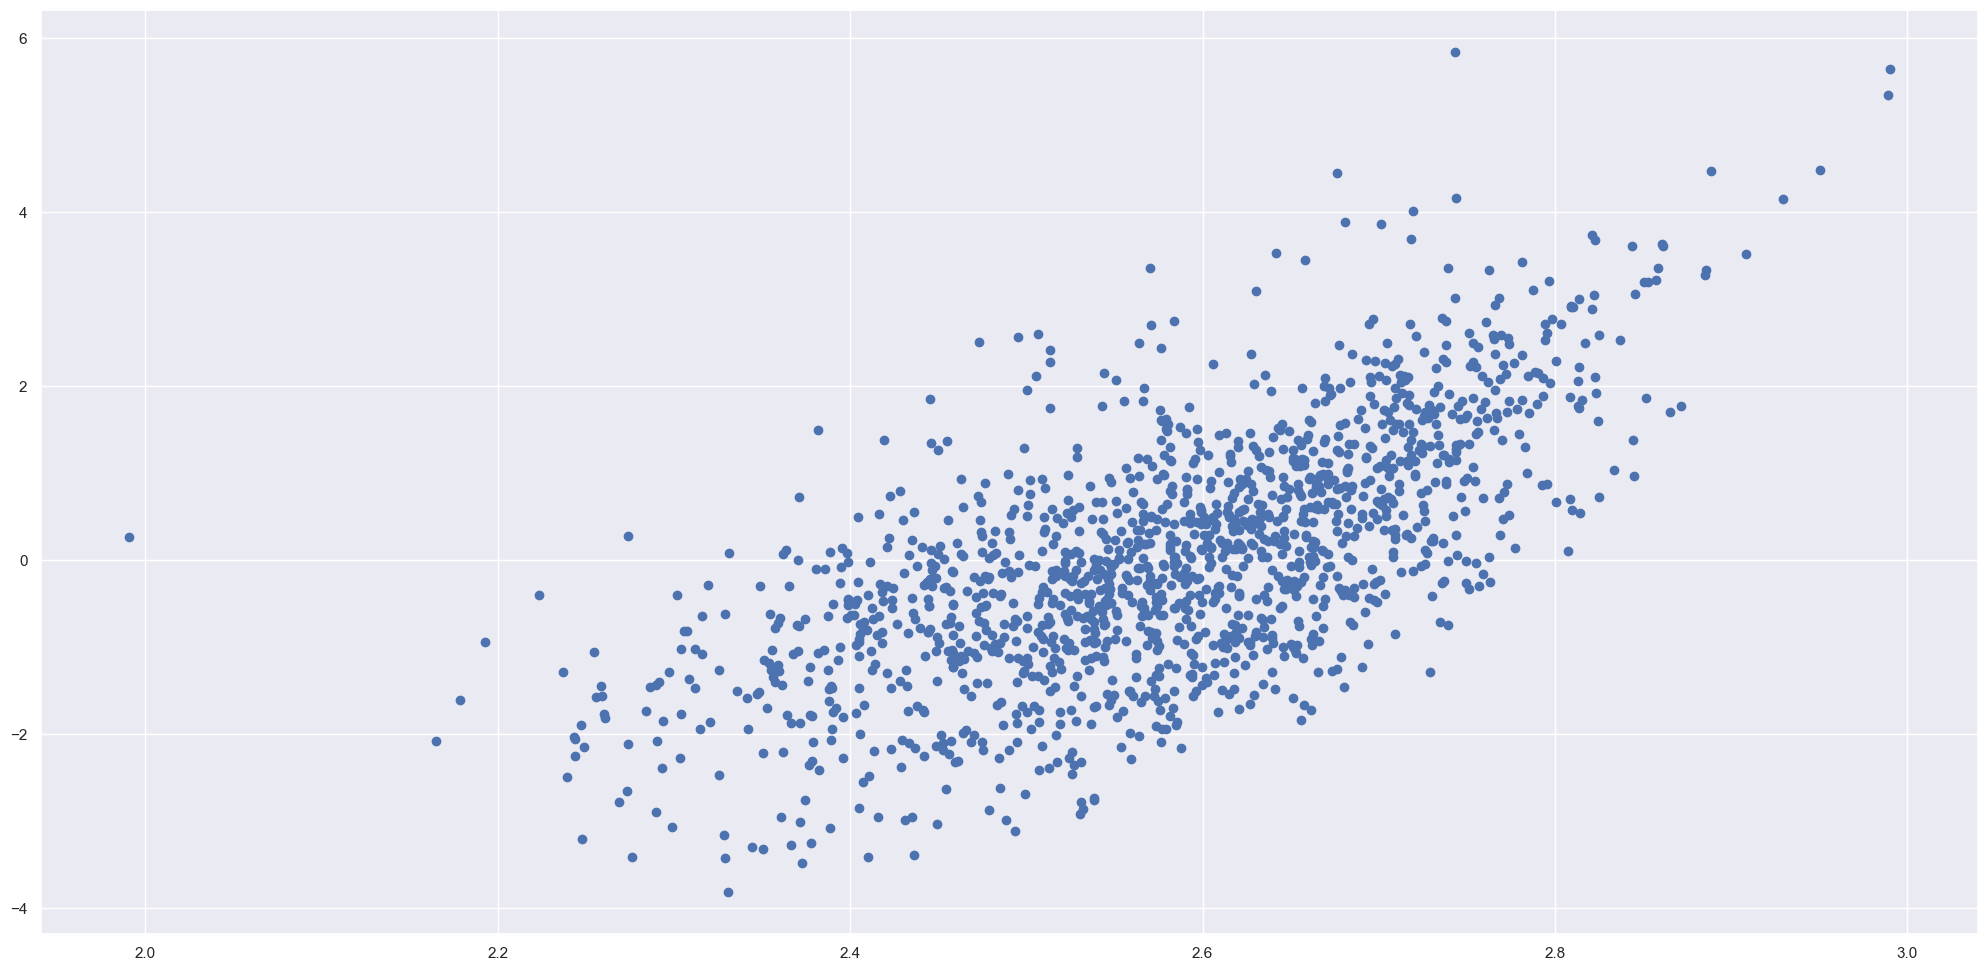

In [ ]:
# Test to see if participants lined up with their own data. There should be a high correlation between original
# data and the deviation score. 

#for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
print(plt.scatter(all_data[[idp]], Deviation_scores[[idp]]))
plt.show()

# Plot

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24746175]), 'Rho': array([0.31906839]), 'pRho': array([8.67813007e-21]), 'SMSE': array([0.985559]), 'EXPV': array([0.01667528])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24224993]), 'Rho': array([0.28830506]), 'pRho': array([4.33726568e-15]), 'SMSE': array([1.09036967]), 'EXPV': array([-0.0863668])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20158572]), 'Rho': array([0.20541717]), 'pRho': array([3.77118095e-09]), 'SMSE': array([1.01036314]), 'EXPV': array([-0.01015713])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array

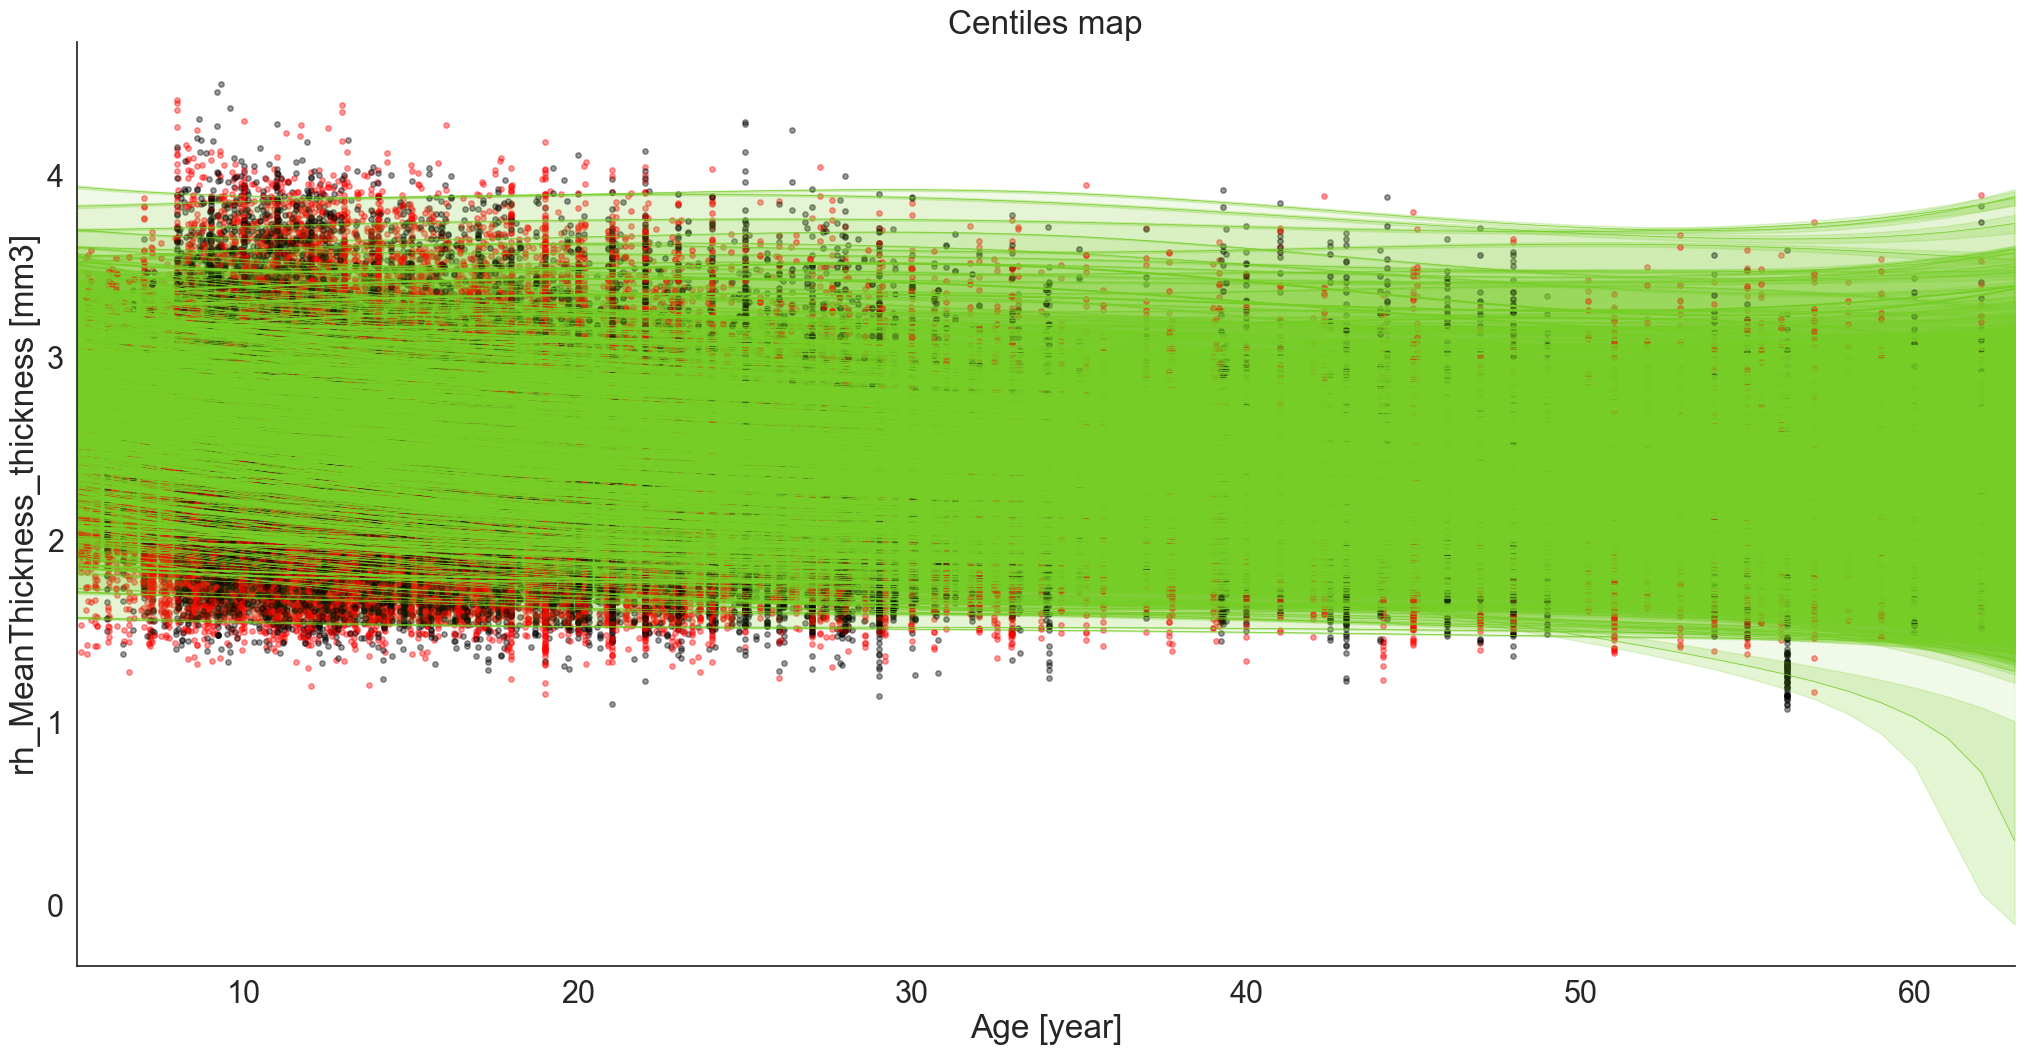

In [ ]:
sets = ['te', 'tr'] #We plot both test and train in the plot so here define names of the sets.

##### Function to get only the ROI name ####

def hyphen_split(a):
    if a.count("_") == 1:
        return a.split("_")[0]
    return "_".join(a.split("_", 2)[:2])


# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x


##### Plot #####

for idp_num, idp in enumerate(roi_ids): #loop through ROIs
    
    # Set style of plots
    sns.set(style='dark')
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    
    for wset in sets: #Loop through both test and train so we can plot both in one
                
#Load data centriles

        #Load X_te and X_tr
        X_te = load_2d(os.path.join(idp_dir, 'cov_bspline_' + wset + '.txt'))
        
        #Load results 
        results = pd.DataFrame()
        results['Z score'] = np.loadtxt(os.path.join(os.path.join(out_dir, idp),'Z_'+ wset +'.txt')).copy()
        
        #Load the carriers data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + wset + '.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + wset + '.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_' + wset + '.txt'))
        
        #Load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_'+ suffix + '.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 
            
            
#Creaty dummy matrix

        xx = np.arange(params['xmin'], params['xmax'])
        
        X0_dummy = np.zeros((len(xx), len(params['cols_cov'])))
        X0_dummy[:,0] = xx
        X0_dummy[:,1] = np.mean(all_data['FIQ'])
        X0_dummy[:,2] = np.mean(all_data['meanEULER'])
        
        # create the design matrix
        X_dummy = create_design_matrix(X0_dummy, 
                                       xmin=params['xmin'], 
                                       xmax=params['xmax'], 
                                       site_ids=None, 
                                       all_sites=params['site_ids'],
                                       basis = params['basis'],
                                       nknots = params['nknots'])

        # save the dummy covariates
        cov_file_dummy = os.path.join(params['out_dir'],'cov_bspline_dummy_mean_' + '.txt')
        np.savetxt(cov_file_dummy, X_dummy) 
        
       
#Set up covariates for the dummy data

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                            alg = params['algo'], 
                            respfile = None, 
                            model_path = os.path.join(idp_dir,'Models'),
                            warp = params['warp'], warp_reparam = params['warp'] is not None, 
                            outputsuffix = '_dummy_')
    
        
#Warping
        
    
        # get the warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

# extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        
#Set parameters for plot

        params_plot = {  'med' : med,
                'yhat' : yhat,
                'W' : W,
                'warp_param': warp_param,
                's2' : s2,
                's2s' : s2s,
                'xx' : xx,
                'idp' :  idp, 
                'idp_dir' : idp_dir,  
             }
        
        
#Resclae y_te
        
        y_te_rescaled = y_te.copy()
        y_te_rescaled = y_te - np.median(y_te) + np.median(med)

# Plot the data not per site 

        # Set style for plot
        sns.despine()
        plt.rc('figure', figsize=(12, 12))
        sns.set(font_scale=2, style="white")

        
        #Set colors for sets
        if wset == 'te':
            color = 'red'
        else:
            color = 'black'
        
        #Scatter plot
        plt.scatter(X_te[:,1], y_te_rescaled, s=15, color=color, alpha = 0.4)
        
    plt.plot(params_plot['xx'], params_plot['med'], '#76cd26')
    
    
#Go through all centriles and fill in between centriles

    for percentiles in [[0.25,0.75], [0.05,0.95]] :#, [0.01,0.99]] :
        # fill the gaps in between the centiles
        junk, pr_int = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']), params_plot['warp_param'], percentiles=percentiles)
        plt.fill_between(params_plot['xx'], pr_int[:,0], pr_int[:,1], alpha = 0.1, color='#76cd26')

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_intl = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']-0.5*params_plot['s2s']), params_plot['warp_param'], percentiles=percentiles)
        junk, pr_intu = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']+0.5*params_plot['s2s']), params_plot['warp_param'], percentiles=percentiles)
        plt.fill_between(params_plot['xx'], pr_intl[:,0], pr_intu[:,0], alpha = 0.2, color='#76cd26')
        plt.fill_between(params_plot['xx'], pr_intl[:,1], pr_intu[:,1], alpha = 0.2, color='#76cd26')

        # plot actual centile lines
        plt.plot(params_plot['xx'], pr_int[:,0],color='#76cd26', linewidth=0.5)
        plt.plot(params_plot['xx'], pr_int[:,1],color='#76cd26', linewidth=0.5)

          
        
    plt.xlabel('Age [year]')
    plt.ylabel(idp + ' [mm3]') 
    plt.xlim((params['xmin'],params['xmax']-1))

    plt.title('Centiles map')
    
    # Save plots in output directory.
    plt.savefig(os.path.join(params_plot['idp_dir'], '_centiles_' + params_plot['idp'] + '_adj_sites' +'.png'))
    plt.show()

# Plot deviation scores in brain space


First load the deviation score dataframe. Then format this to a long format. 

In [14]:
#Load data
os.chdir('/Volumes/methlab/Students/Jente/Scripts_ASD_analysis_final/python_scripts/ASD_model')
Z_df = pd.read_csv('results/blr/powell/outputs/Deviation_scores.csv')

#Reshape to long
Z_df = pd.melt(Z_df, id_vars='SUB_ID', value_vars=roi_ids, var_name='ROI', value_name= 'CT')


We need to have a column with the left and right hemisphere seperately. So make a column and then change the name of the ROI column so it does not contain this info anymore. Also, the names now include 'thickness' at the end. This should be gone as well.

In [15]:
Z_df['hemi'] = Z_df['ROI'].str.slice(0,2)
Z_df['ROI'] = Z_df['ROI'].str.slice(3,-10)
Z_df.to_csv(os.path.join(result_dir, 'Z_df.csv'))

Load the Z_df data

In [16]:
Z_df = pd.read_csv('results/Z_df.csv')


Then we load the atlas surface we want to use to plot the results on.

In [17]:
## Select atlas etc. 
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage()

# The parcellation is already loaded into memory
parcellation_l = destrieux_atlas['map_left']
parcellation_r = destrieux_atlas['map_right']

# Our data needs to be in the same order as the atlas so this is the order in which the atlas is presented. 
nl = pd.read_csv('data/nilearn_order.csv')

# Define the left and right hemisphere of the atlas
atlas_r = destrieux_atlas['map_right']
atlas_l = destrieux_atlas['map_left']

#Define the ROIs
nl_ROI = nl['ROI'].to_list()

# Plot deviation scores in brain space for ASD

We plot the overlap of significant regions in percentage.

In [18]:
#Select participants with ASD:

sub_ids_ASD = all_data_ASD['SUB_ID']

Z_df_ASD = Z_df[Z_df['SUB_ID'].isin(sub_ids_ASD)]


In [19]:
# Set threshold for significant deviations. A significant deviation is defined by a p_value of 0.005 which matches a deviation score of 2.6
Z_positive_ASD = Z_df_ASD.query('CT > 2.6')
Z_negative_ASD = Z_df_ASD.query('CT < -2.6')


In [20]:
#Select positive and negative data for left and right hemisphere
positive_left_z_ASD = Z_positive_ASD.query('hemi == "lh"')
positive_right_z_ASD = Z_positive_ASD.query('hemi == "rh"')
negative_left_z_ASD = Z_negative_ASD.query('hemi == "lh"')
negative_right_z_ASD = Z_negative_ASD.query('hemi == "rh"')

#Count how many participant have significant deviations in each area and save
positive_left_z2_ASD = positive_left_z_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_z2_ASD = positive_right_z_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_z2_ASD = negative_left_z_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_z2_ASD = negative_right_z_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

#Calcualte percentage of people with significant deviations
positive_left_z2_ASD['percentage'] = positive_left_z2_ASD['counts'] / len(sub_ids_ASD) * 100
positive_right_z2_ASD['percentage'] = positive_right_z2_ASD['counts'] / len(sub_ids_ASD) * 100
negative_left_z2_ASD['percentage'] = negative_left_z2_ASD['counts'] / len(sub_ids_ASD) * 100
negative_right_z2_ASD['percentage'] = negative_right_z2_ASD['counts'] / len(sub_ids_ASD) * 100

# Read to csv so we can do statistics on this in R
positive_left_z2_ASD.to_csv(os.path.join(result_dir,'positive_left_z2_ASD.csv'))
positive_right_z2_ASD.to_csv(os.path.join(result_dir,'positive_right_z2_ASD.csv'))
negative_left_z2_ASD.to_csv(os.path.join(result_dir,'negative_left_z2_ASD.csv'))
negative_right_z2_ASD.to_csv(os.path.join(result_dir,'negative_right_z2_ASD.csv'))


### Extreme positive deviation viz

In [21]:
#Merge with atlas
nl_positive_left_ASD = pd.merge(nl, positive_left_z2_ASD , on='ROI', how='left')
nl_positive_right_ASD  = pd.merge(nl, positive_right_z2_ASD , on='ROI', how='left')

# Fill NA's with 0s and reformat to numpy. 
nl_positive_left_ASD['percentage'] = nl_positive_left_ASD['percentage'].fillna(0)
nl_positive_right_ASD['percentage'] = nl_positive_right_ASD['percentage'].fillna(0)

nl_positive_left_ASD_perc = nl_positive_left_ASD['percentage'].to_numpy()
nl_positive_right_ASD_perc = nl_positive_right_ASD['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_ASD_perc = atlas_l
for i, j in enumerate(a_list):
    parcellation_positive_l_ASD_perc = np.where(atlas_l == j, nl_positive_left_ASD_perc[i], parcellation_positive_l_ASD_perc)

a_list = list(range(1, 76))
parcellation_positive_r_ASD_perc = atlas_r
for i, j in enumerate(a_list):
    parcellation_positive_r_ASD_perc = np.where(atlas_r == j, nl_positive_right_ASD_perc[i], parcellation_positive_r_ASD_perc)   


In [22]:
#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_ASD_perc, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh ASD', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_ASD_perc.html'))
view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_ASD_perc, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh ASD', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_ASD_perc.html'))


### Extreme negative deviation viz

In [23]:
#Merge with atlas
nl_negative_left_ASD = pd.merge(nl, negative_left_z2_ASD , on='ROI', how='left')
nl_negative_right_ASD  = pd.merge(nl, negative_right_z2_ASD , on='ROI', how='left')

# Fill NA's with 0s and reformat to numpy. 
nl_negative_left_ASD['percentage'] = nl_negative_left_ASD['percentage'].fillna(0)
nl_negative_right_ASD['percentage'] = nl_negative_right_ASD['percentage'].fillna(0)

nl_negative_left_ASD_perc = nl_negative_left_ASD['percentage'].to_numpy()
nl_negative_right_ASD_perc = nl_negative_right_ASD['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_ASD_perc = atlas_l
for i, j in enumerate(a_list):
    parcellation_negative_l_ASD_perc = np.where(atlas_l == j, nl_negative_left_ASD_perc[i], parcellation_negative_l_ASD_perc)

a_list = list(range(1, 76))
parcellation_negative_r_ASD_perc = atlas_r
for i, j in enumerate(a_list):
    parcellation_negative_r_ASD_perc = np.where(atlas_r == j, nl_negative_right_ASD_perc[i], parcellation_negative_r_ASD_perc)   


In [24]:
#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_ASD_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh ASD', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_ASD_perc.html'))
view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_ASD_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh ASD', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_ASD_perc.html'))

# Plot deviation scores in brain space for all TC

In [25]:
#Select TC

sub_ids_TC = all_data_TC['SUB_ID']

Z_df_TC = Z_df[Z_df['SUB_ID'].isin(sub_ids_TC)]


In [26]:
# Set threshold for significant deviations. A significant deviation is defined by a p_value of 0.005 which matches a deviation score of 2.6
Z_positive_TC = Z_df_TC.query('CT > 2.6')
Z_negative_TC = Z_df_TC.query('CT < -2.6')


In [27]:
#Select positive and negative data for left and right hemisphere
positive_left_z_TC = Z_positive_TC.query('hemi == "lh"')
positive_right_z_TC = Z_positive_TC.query('hemi == "rh"')
negative_left_z_TC = Z_negative_TC.query('hemi == "lh"')
negative_right_z_TC = Z_negative_TC.query('hemi == "rh"')

#Count how many participant have significant deviations in each area and save
positive_left_z2_TC = positive_left_z_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_z2_TC = positive_right_z_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_z2_TC = negative_left_z_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_z2_TC = negative_right_z_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

#Calcualte percentage of people with significant deviations
positive_left_z2_TC['percentage'] = positive_left_z2_TC['counts'] / len(all_data_TC['SUB_ID']) * 100
positive_right_z2_TC['percentage'] = positive_right_z2_TC['counts'] / len(all_data_TC['SUB_ID']) * 100
negative_left_z2_TC['percentage'] = negative_left_z2_TC['counts'] / len(all_data_TC['SUB_ID']) * 100
negative_right_z2_TC['percentage'] = negative_right_z2_TC['counts'] / len(all_data_TC['SUB_ID']) * 100

# Read to csv so we can do statistics on these in R
positive_left_z2_TC.to_csv(os.path.join(result_dir,'positive_left_z2_TC.csv'))
positive_right_z2_TC.to_csv(os.path.join(result_dir,'positive_right_z2_TC.csv'))
negative_left_z2_TC.to_csv(os.path.join(result_dir,'negative_left_z2_TC.csv'))
negative_right_z2_TC.to_csv(os.path.join(result_dir,'negative_right_z2_TC.csv'))


### Extreme positive deviation viz

In [28]:
# Merge with atlas
nl_positive_left_TC = pd.merge(nl, positive_left_z2_TC , on='ROI', how='left')
nl_positive_right_TC  = pd.merge(nl, positive_right_z2_TC , on='ROI', how='left')

# Fill NA's with 0s and reformat to numpy. 
nl_positive_left_TC['percentage'] = nl_positive_left_TC['percentage'].fillna(0)
nl_positive_right_TC['percentage'] = nl_positive_right_TC['percentage'].fillna(0)

nl_positive_left_TC_perc = nl_positive_left_TC['percentage'].to_numpy()
nl_positive_right_TC_perc = nl_positive_right_TC['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_TC_perc = atlas_l
for i, j in enumerate(a_list):
    parcellation_positive_l_TC_perc = np.where(atlas_l == j, nl_positive_left_TC_perc[i], parcellation_positive_l_TC_perc)

a_list = list(range(1, 76))
parcellation_positive_r_TC_perc = atlas_r
for i, j in enumerate(a_list):
    parcellation_positive_r_TC_perc = np.where(atlas_r == j, nl_positive_right_TC_perc[i], parcellation_positive_r_TC_perc)   


In [29]:
#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_TC_perc, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh TC', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_TC_perc.html'))
view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_TC_perc, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh TC', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_TC_perc.html'))

### Extreme negative deviation viz

In [30]:
# Merge with atlas
nl_negative_left_TC = pd.merge(nl, negative_left_z2_TC , on='ROI', how='left')
nl_negative_right_TC  = pd.merge(nl, negative_right_z2_TC , on='ROI', how='left')

# Fill NA's with 0s and reformat to numpy. 
nl_negative_left_TC['percentage'] = nl_negative_left_TC['percentage'].fillna(0)
nl_negative_right_TC['percentage'] = nl_negative_right_TC['percentage'].fillna(0)

nl_negative_left_TC_perc = nl_negative_left_TC['percentage'].to_numpy()
nl_negative_right_TC_perc = nl_negative_right_TC['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_TC_perc = atlas_l
for i, j in enumerate(a_list):
    parcellation_negative_l_TC_perc = np.where(atlas_l == j, nl_negative_left_TC_perc[i], parcellation_negative_l_TC_perc)

a_list = list(range(1, 76))
parcellation_negative_r_TC_perc = atlas_r
for i, j in enumerate(a_list):
    parcellation_negative_r_TC_perc = np.where(atlas_r == j, nl_negative_right_TC_perc[i], parcellation_negative_r_TC_perc)   


In [31]:
#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_TC_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh TC', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_TC_perc.html'))
view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_TC_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh TC', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_TC_perc.html'))

# Plot extreme deviations seperately for each subtype

For this part of the code, we use data which we create in R. So make sure to run the normative modelling part in R before this part is run. 

In [32]:
# Load data
Z_df_1 = pd.read_csv('results/Z_df_subtype1.csv')
Z_df_2 = pd.read_csv('results/Z_df_subtype2.csv')

In [33]:
# Set threshold for significant deviations. A significant deviation is defined by a p_value of 0.005 which matches a deviation score of 2.6
Z_positive_1 = Z_df_1.query('CT > 2.6')
Z_negative_1 = Z_df_1.query('CT < -2.6')

Z_positive_2 = Z_df_2.query('CT > 2.6')
Z_negative_2 = Z_df_2.query('CT < -2.6')

In [34]:
# Calculate the percentages
#subtype 1
positive_left_z_1 = Z_positive_1.query('hemi == "lh"')
positive_right_z_1 = Z_positive_1.query('hemi == "rh"')
negative_left_z_1 = Z_negative_1.query('hemi == "lh"')
negative_right_z_1 = Z_negative_1.query('hemi == "rh"')

positive_left_z2_1 = positive_left_z_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_z2_1 = positive_right_z_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_z2_1 = negative_left_z_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_z2_1 = negative_right_z_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_z2_1['percentage'] = positive_left_z2_1['counts'] / len(np.unique(Z_df_1.SUB_ID)) * 100
positive_right_z2_1['percentage'] = positive_right_z2_1['counts'] / len(np.unique(Z_df_1.SUB_ID)) * 100
negative_left_z2_1['percentage'] = negative_left_z2_1['counts'] / len(np.unique(Z_df_1.SUB_ID)) * 100
negative_right_z2_1['percentage'] = negative_right_z2_1['counts'] / len(np.unique(Z_df_1.SUB_ID)) * 100

# Read to csv so we can do statistics on these in R
positive_left_z2_1.to_csv(os.path.join(result_dir,'positive_left_z2_1.csv'))
positive_right_z2_1.to_csv(os.path.join(result_dir,'positive_right_z2_1.csv'))
negative_left_z2_1.to_csv(os.path.join(result_dir,'negative_left_z2_1.csv'))
negative_right_z2_1.to_csv(os.path.join(result_dir,'negative_right_z2_1.csv'))


#Subtype 2
positive_left_z_2 = Z_positive_2.query('hemi == "lh"')
positive_right_z_2 = Z_positive_2.query('hemi == "rh"')
negative_left_z_2 = Z_negative_2.query('hemi == "lh"')
negative_right_z_2 = Z_negative_2.query('hemi == "rh"')

positive_left_z2_2 = positive_left_z_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_z2_2 = positive_right_z_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_z2_2 = negative_left_z_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_z2_2 = negative_right_z_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_z2_2['percentage'] = positive_left_z2_2['counts'] / len(np.unique(Z_df_2.SUB_ID)) * 100
positive_right_z2_2['percentage'] = positive_right_z2_2['counts'] / len(np.unique(Z_df_2.SUB_ID)) * 100
negative_left_z2_2['percentage'] = negative_left_z2_2['counts'] / len(np.unique(Z_df_2.SUB_ID)) * 100
negative_right_z2_2['percentage'] = negative_right_z2_2['counts'] / len(np.unique(Z_df_2.SUB_ID)) * 100

# Read to csv so we can do statistics on these in R
positive_left_z2_2.to_csv(os.path.join(result_dir,'positive_left_z2_2.csv'))
positive_right_z2_2.to_csv(os.path.join(result_dir,'positive_right_z2_2.csv'))
negative_left_z2_2.to_csv(os.path.join(result_dir,'negative_left_z2_2.csv'))
negative_right_z2_2.to_csv(os.path.join(result_dir,'negative_right_z2_2.csv'))

## Extreme positive deviations


In [35]:

## Plot extreme positive deviations for subtype 1
nl_positive_left_1 = pd.merge(nl, positive_left_z2_1 , on='ROI', how='left')
nl_positive_right_1  = pd.merge(nl, positive_right_z2_1 , on='ROI', how='left')


#Percentages
nl_positive_left_1['percentage'] = nl_positive_left_1['percentage'].fillna(0)
nl_positive_right_1['percentage'] = nl_positive_right_1['percentage'].fillna(0)

nl_positive_left_1_perc = nl_positive_left_1['percentage'].to_numpy()
nl_positive_right_1_perc = nl_positive_right_1['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_1_perc = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_1_perc = np.where(atlas_l == j, nl_positive_left_1_perc[i], parcellation_positive_l_1_perc)

a_list = list(range(1, 76))
parcellation_positive_r_1_perc = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_1_perc = np.where(atlas_r == j, nl_positive_right_1_perc[i], parcellation_positive_r_1_perc)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_1_perc, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh 1', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_sub1_perc.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_1_perc, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh 1', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_sub1_perc.html'))



## Plot extreme positive deviations for subtype 2

nl_positive_left_2 = pd.merge(nl, positive_left_z2_2 , on='ROI', how='left')
nl_positive_right_2  = pd.merge(nl, positive_right_z2_2 , on='ROI', how='left')


#Percentages
nl_positive_left_2['percentage'] = nl_positive_left_2['percentage'].fillna(0)
nl_positive_right_2['percentage'] = nl_positive_right_2['percentage'].fillna(0)

nl_positive_left_2_perc = nl_positive_left_2['percentage'].to_numpy()
nl_positive_right_2_perc = nl_positive_right_2['percentage'].to_numpy()


a_list = list(range(2, 76))
parcellation_positive_l_2_perc = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_2_perc = np.where(atlas_l == j, nl_positive_left_2_perc[i], parcellation_positive_l_2_perc)

a_list = list(range(2, 76))
parcellation_positive_r_2_perc = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_2_perc = np.where(atlas_r == j, nl_positive_right_2_perc[i], parcellation_positive_r_2_perc)   



#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_2_perc, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh 2', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_sub2_perc.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_2_perc, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh 2', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_sub2_perc.html'))


## Extreme negative deviations

In [36]:

## Plot extreme negative deviations for subtype 1
nl_negative_left_1 = pd.merge(nl, negative_left_z2_1 , on='ROI', how='left')
nl_negative_right_1  = pd.merge(nl, negative_right_z2_1 , on='ROI', how='left')


#Percentages
nl_negative_left_1['percentage'] = nl_negative_left_1['percentage'].fillna(0)
nl_negative_right_1['percentage'] = nl_negative_right_1['percentage'].fillna(0)

nl_negative_left_1_perc = nl_negative_left_1['percentage'].to_numpy()
nl_negative_right_1_perc = nl_negative_right_1['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_1_perc = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_1_perc = np.where(atlas_l == j, nl_negative_left_1_perc[i], parcellation_negative_l_1_perc)

a_list = list(range(1, 76))
parcellation_negative_r_1_perc = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_1_perc = np.where(atlas_r == j, nl_negative_right_1_perc[i], parcellation_negative_r_1_perc)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_1_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh 1', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_sub1_perc.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_1_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh 1', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_sub1_perc.html'))



## Plot extreme negative deviations for subtype 2

nl_negative_left_2 = pd.merge(nl, negative_left_z2_2 , on='ROI', how='left')
nl_negative_right_2  = pd.merge(nl, negative_right_z2_2 , on='ROI', how='left')


#Percentages
nl_negative_left_2['percentage'] = nl_negative_left_2['percentage'].fillna(0)
nl_negative_right_2['percentage'] = nl_negative_right_2['percentage'].fillna(0)

nl_negative_left_2_perc = nl_negative_left_2['percentage'].to_numpy()
nl_negative_right_2_perc = nl_negative_right_2['percentage'].to_numpy()


a_list = list(range(2, 76))
parcellation_negative_l_2_perc = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_2_perc = np.where(atlas_l == j, nl_negative_left_2_perc[i], parcellation_negative_l_2_perc)

a_list = list(range(2, 76))
parcellation_negative_r_2_perc = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_2_perc = np.where(atlas_r == j, nl_negative_right_2_perc[i], parcellation_negative_r_2_perc)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_2_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh 2', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_sub2_perc.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_2_perc, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh 2', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_sub2_perc.html'))


# Statistic maps

We want to see the heterogeneity in the deviation scores in autism. We therefore plot the top 10 people with autism with the most extreme deviations in a stats plot.

## Top 10 for all ASD

We calculated the p values in R. Let's load this data and then we can use this to plot the p values in a brain plot for the most deviating participants like they did in Marquand et al. (2016)

In [37]:
P_df = pd.read_csv('results/P_df.csv')
P_df["ROI"] = P_df['ROI'].str.replace('.', '_')


/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/2257097199.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  P_df["ROI"] = P_df['ROI'].str.replace('.', '_')


In [38]:
#Get data for ASD alone
P_df_ASD = P_df[P_df['SUB_ID'].isin(sub_ids_ASD)]

Now make a new column with the deviation scores that are significant. If it's not significant, set the row at 0. 

In [39]:
P_df_ASD["Z_sig"] = P_df_ASD["CT"]
P_df_ASD.loc[P_df_ASD["pvalue"] > 0.005, "Z_sig"] = 0


/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/3638966668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_df_ASD["Z_sig"] = P_df_ASD["CT"]


Now we want to plot the 10 participants with the most deviation. Let's use the top 10 participants with the most significant results


In [40]:
len_sig = pd.DataFrame(columns = ['len_sig'], index = [np.unique(P_df_ASD["SUB_ID"])])

for sub in np.unique(P_df_ASD["SUB_ID"]):
    #First select the data for the participant in this loop
    data_sub = P_df_ASD[P_df_ASD["SUB_ID"]== sub]
    data_sub = data_sub[data_sub["pvalue"]<0.005]

    #Then save length of significant results in a dataframe with SUB_ID

    len_sig.loc[sub,:] = len(data_sub)

#Then select the 10 participants with the most significant results
top_subs = len_sig.sort_values('len_sig').tail(10)
top_subs = list(top_subs.index)

Split into left and right hemispheres

In [41]:
left_df_ASD = P_df_ASD[P_df_ASD["hemi"]=='lh']
right_df_ASD = P_df_ASD[P_df_ASD["hemi"]=='rh']

Start a for loop that will plot the results for each participant we selected before. 

In [42]:
# First for left hemisphere 
for sub in top_subs:

    # Select the data for this specific subject
    left_df_ASD_sub = left_df_ASD[left_df_ASD["SUB_ID"]==sub]

    # Merge with atlas
    nl_left_df_ASD = pd.merge(nl, left_df_ASD_sub, on="ROI", how="left")
    

    #Create numpy
    nl_left_df_ASD["Z_sig"] = nl_left_df_ASD["Z_sig"].fillna(0)

    nl_left_df_ASD_Z = nl_left_df_ASD["Z_sig"].to_numpy()


    a_list = list(range(1,76))
    parcellation_l_ASD = atlas_l
    for i, j in enumerate(a_list):
        parcellation_l_ASD = np.where(atlas_l == j, nl_left_df_ASD_Z[i], parcellation_l_ASD)


    # Plot 
    view = plotting.view_surf(fsaverage.infl_left, parcellation_l_ASD, threshold=None, vmax = 5, cmap='coolwarm', bg_map = fsaverage.sulc_left, title = "Significant lh deviation scores for subject: %i " %sub, title_fontsize=15)
    view.save_as_html(os.path.join(statsplot_dir, 'lh_stats_%i' %sub + '.html'))



In [43]:
# Then right hemisphere
for sub in top_subs:

    # Select the data for this specific subject
    right_df_ASD_sub = right_df_ASD[right_df_ASD["SUB_ID"]==sub]

    # Merge with atlas
    nl_right_df_ASD = pd.merge(nl, right_df_ASD_sub, on="ROI", how="left")

    #Create numpy
    nl_right_df_ASD["Z_sig"] = nl_right_df_ASD["Z_sig"].fillna(0)

    nl_right_df_ASD_Z = nl_right_df_ASD["Z_sig"].to_numpy()


    a_list = list(range(1,76))
    parcellation_r_ASD = atlas_r
    for i, j in enumerate(a_list):
        parcellation_r_ASD = np.where(atlas_r == j, nl_right_df_ASD_Z[i], parcellation_r_ASD)


    view = plotting.view_surf(fsaverage.infl_right, parcellation_r_ASD, threshold=None, vmax=5, cmap='coolwarm', bg_map = fsaverage.sulc_right, title = "Significant rh deviation scores for subject: %i " %sub, title_fontsize=15)
    view.save_as_html(os.path.join(statsplot_dir, 'rh_stats_%i' %sub + '.html'))





## Top 10 for each subtype seperately

We do the same but then for each subtype seperately.

In [44]:
#Get dataframe for each subtype seperately
P_df_sub1 = P_df[P_df["SUB_ID"].isin(np.unique(Z_df_1.SUB_ID))]
P_df_sub2 = P_df[P_df["SUB_ID"].isin(np.unique(Z_df_2.SUB_ID))]

Now make a new column with the deviation scores that are significant. If it's not significant, set the row at 0. 

In [45]:
P_df_sub1["Z_sig"] = P_df_sub1["CT"]
P_df_sub1.loc[P_df_sub1["pvalue"] > 0.005, "Z_sig"] = 0

P_df_sub2["Z_sig"] = P_df_sub2["CT"]
P_df_sub2.loc[P_df_sub2["pvalue"] > 0.005, "Z_sig"] = 0

/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/800120572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_df_sub1["Z_sig"] = P_df_sub1["CT"]
/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/800120572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_df_sub2["Z_sig"] = P_df_sub2["CT"]


Now we want to plot the 10 participants with the most deviation. Let's use the top 10 participants with the most significant results


In [46]:
## For subtype 1
len_sig1 = pd.DataFrame(columns = ['len_sig'], index = [np.unique(P_df_sub1["SUB_ID"])])

for sub in np.unique(P_df_sub1["SUB_ID"]):
    #First select the data for the participant in this loop
    data_sub1 = P_df_sub1[P_df_sub1["SUB_ID"]== sub]
    data_sub1 = data_sub1[data_sub1["pvalue"]<0.005]

    #Then save length of significant results in a dataframe with SUB_ID

    len_sig1.loc[sub,:] = len(data_sub1)

#Then select the 10 participants with the most significant results
top_subs1 = len_sig1.sort_values('len_sig').tail(10)
top_subs1 = list(top_subs1.index)


## For subtype 2
len_sig2 = pd.DataFrame(columns = ['len_sig'], index = [np.unique(P_df_sub2["SUB_ID"])])

for sub in np.unique(P_df_sub2["SUB_ID"]):
    #First select the data for the participant in this loop
    data_sub2 = P_df_sub2[P_df_sub2["SUB_ID"]== sub]
    data_sub2 = data_sub2[data_sub2["pvalue"]<0.005]

    #Then save length of significant results in a dataframe with SUB_ID

    len_sig2.loc[sub,:] = len(data_sub2)

#Then select the 10 participants with the most significant results
top_subs2 = len_sig2.sort_values('len_sig').tail(10)
top_subs2 = list(top_subs2.index)

Split into left and right hemisphere

In [47]:
left_df_sub1 = P_df_sub1[P_df_sub1["hemi"]=='lh']
right_df_sub1 = P_df_sub1[P_df_sub1["hemi"]=='rh']

left_df_sub2 = P_df_sub2[P_df_sub2["hemi"]=='lh']
right_df_sub2 = P_df_sub2[P_df_sub2["hemi"]=='rh']

Start a for loop that will plot the results for each participant we selected before. 

In [48]:
# First for left hemisphere 

# Subtype 1
for sub in top_subs1:
  # Select the data for this specific subject
  left_df_sub1_sub = left_df_sub1[left_df_sub1["SUB_ID"]==sub]

  # Merge with atlas
  nl_left_df_sub1 = pd.merge(nl, left_df_sub1_sub, on="ROI", how="left")


  #Create numpy
  nl_left_df_sub1["Z_sig"] = nl_left_df_sub1["Z_sig"].fillna(0)

  nl_left_df_sub1_Z = nl_left_df_sub1["Z_sig"].to_numpy()


  a_list = list(range(1,76))
  parcellation_l_sub1 = atlas_l
  for i, j in enumerate(a_list):
    parcellation_l_sub1 = np.where(atlas_l == j, nl_left_df_sub1_Z[i], parcellation_l_sub1)


  # Plot 
  view = plotting.view_surf(fsaverage.infl_left, parcellation_l_sub1, threshold=None, vmax = 5, cmap='coolwarm', bg_map = fsaverage.sulc_left, title = "Significant lh deviation scores for subject: %i " %sub, title_fontsize=15)
  view.save_as_html(os.path.join(statsplot_dir, 'sub1_lh_stats_%i' %sub + '.html'))


  # Subtype 2
for sub in top_subs2:
  
  # Select the data for this specific subject
  left_df_sub2_sub = left_df_sub2[left_df_sub2["SUB_ID"]==sub]

  # Merge with atlas
  nl_left_df_sub2 = pd.merge(nl, left_df_sub2_sub, on="ROI", how="left")


  #Create numpy
  nl_left_df_sub2["Z_sig"] = nl_left_df_sub2["Z_sig"].fillna(0)

  nl_left_df_sub2_Z = nl_left_df_sub2["Z_sig"].to_numpy()


  a_list = list(range(1,76))
  parcellation_l_sub2 = atlas_l
  for i, j in enumerate(a_list):
    parcellation_l_sub2 = np.where(atlas_l == j, nl_left_df_sub2_Z[i], parcellation_l_sub2)


  # Plot 
  view = plotting.view_surf(fsaverage.infl_left, parcellation_l_sub2, threshold=None, vmax = 5, cmap='coolwarm', bg_map = fsaverage.sulc_left, title = "Significant lh deviation scores for subject: %i " %sub, title_fontsize=15)
  view.save_as_html(os.path.join(statsplot_dir, 'sub2_lh_stats_%i' %sub + '.html'))

  

In [49]:
# First for right hemisphere 

# Subtype 1
for sub in top_subs1:
  
  # Select the data for this specific subject
  right_df_sub1_sub = right_df_sub1[right_df_sub1["SUB_ID"]==sub]
  
  # Merge with atlas
  nl_right_df_sub1 = pd.merge(nl, right_df_sub1_sub, on="ROI", how="right")
  
  
  #Create numpy
  nl_right_df_sub1["Z_sig"] = nl_right_df_sub1["Z_sig"].fillna(0)
  
  nl_right_df_sub1_Z = nl_right_df_sub1["Z_sig"].to_numpy()
  
  
  a_list = list(range(1,76))
  parcellation_r_sub1 = atlas_r
  for i, j in enumerate(a_list):
    parcellation_r_sub1 = np.where(atlas_r == j, nl_right_df_sub1_Z[i], parcellation_r_sub1)
  
  
  # Plot 
  view = plotting.view_surf(fsaverage.infl_right, parcellation_r_sub1, threshold=None, vmax = 5, cmap='coolwarm', bg_map = fsaverage.sulc_right, title = "Significant rh deviation scores for subject: %i " %sub, title_fontsize=15)
  view.save_as_html(os.path.join(statsplot_dir, 'sub1_rh_stats_%i' %sub + '.html'))
  
  
  # Subtype 2
for sub in top_subs2:
    
  # Select the data for this specific subject
  right_df_sub2_sub = right_df_sub2[right_df_sub2["SUB_ID"]==sub]
  
  # Merge with atlas
  nl_right_df_sub2 = pd.merge(nl, right_df_sub2_sub, on="ROI", how="right")
  
  
  #Create numpy
  nl_right_df_sub2["Z_sig"] = nl_right_df_sub2["Z_sig"].fillna(0)
  
  nl_right_df_sub2_Z = nl_right_df_sub2["Z_sig"].to_numpy()
  
  
  a_list = list(range(1,76))
  parcellation_r_sub2 = atlas_r
  for i, j in enumerate(a_list):
    parcellation_r_sub2 = np.where(atlas_r == j, nl_right_df_sub2_Z[i], parcellation_r_sub2)
  
  
  # Plot 
  view = plotting.view_surf(fsaverage.infl_right, parcellation_r_sub2, threshold=None, vmax = 5, cmap='coolwarm', bg_map = fsaverage.sulc_right, title = "Significant rh deviation scores for subject: %i " %sub, title_fontsize=15)
  view.save_as_html(os.path.join(statsplot_dir, 'sub2_rh_stats_%i' %sub + '.html'))
  
  

## Prepare dataframe with counts to do statistics in R

In [50]:
# Set threshold for significant deviations. This level is determined in R. 
Z_positive_all = Z_df.query('CT > 2.6')
Z_negative_all = Z_df.query('CT < -2.6')

#Select positive and negative data for left and right hemisphere
positive_left_z_all = Z_positive_all.query('hemi == "lh"')
positive_right_z_all = Z_positive_all.query('hemi == "rh"')
negative_left_z_all = Z_negative_all.query('hemi == "lh"')
negative_right_z_all = Z_negative_all.query('hemi == "rh"')


# Count how many participant have significant deviations in each area and save
positive_left_z2_all = positive_left_z_all['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_z2_all = positive_right_z_all['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_z2_all = negative_left_z_all['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_z2_all = negative_right_z_all['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

# Read to csv so we can do statistics on these in R
positive_left_z2_all.to_csv(os.path.join(result_dir,'positive_left_z2_all.csv'))
positive_right_z2_all.to_csv(os.path.join(result_dir,'positive_right_z2_all.csv'))
negative_left_z2_all.to_csv(os.path.join(result_dir,'negative_left_z2_all.csv'))
negative_right_z2_all.to_csv(os.path.join(result_dir,'negative_left_z2_all.csv'))


# Cohen's d maps

## ASD - TC

In [51]:
# Make deviation scores absolute and combine datasets
ASD_abs = Z_df_ASD
TC_abs = Z_df_TC

ASD_pos = Z_df_ASD[Z_df_ASD['CT'] > 0]
TC_pos = Z_df_TC[Z_df_TC['CT'] > 0]

ASD_neg = Z_df_ASD[Z_df_ASD['CT'] < 0]
TC_neg = Z_df_TC[Z_df_TC['CT'] < 0]


ASD_abs["CT"] = abs(ASD_abs["CT"])
TC_abs["CT"] = abs(TC_abs["CT"])

ASD_neg["CT"] = abs(ASD_neg["CT"])
TC_neg["CT"] = abs(TC_neg["CT"])

ASD_pos["CT"] = abs(ASD_pos["CT"])
TC_pos["CT"] = abs(TC_pos["CT"])

ASD_TC = pd.concat([ASD_abs, TC_abs])
ASD_TC_pos = pd.concat([ASD_pos, TC_pos])
ASD_TC_neg = pd.concat([ASD_neg, TC_neg])


# calculate mean ASD, mean TC, and SD for each ROI
grouped_ASD = ASD_abs.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_TC = TC_abs.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_SD = ASD_TC.groupby(['ROI', 'hemi']).agg({'CT': 'std'}).reset_index().rename(columns={'CT': 'SD'})

grouped_ASD_pos = ASD_pos.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_TC_pos = TC_pos.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_SD_pos = ASD_TC_pos.groupby(['ROI', 'hemi']).agg({'CT': 'std'}).reset_index().rename(columns={'CT': 'SD'})

grouped_ASD_neg = ASD_neg.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_TC_neg = TC_neg.groupby(['ROI', 'hemi']).agg({'CT': 'mean'}).reset_index()
grouped_SD_neg = ASD_TC_neg.groupby(['ROI', 'hemi']).agg({'CT': 'std'}).reset_index().rename(columns={'CT': 'SD'})


# merge dataframes and calculate ratio
merged_df = pd.merge(grouped_ASD, grouped_TC, on=['ROI', 'hemi'], suffixes=('_ASD', '_TC'))
merged_df = pd.merge(merged_df, grouped_SD, on=['ROI', 'hemi'])
merged_df['ratio'] = (merged_df['CT_ASD'] - merged_df['CT_TC']) / merged_df['SD']

merged_df_pos = pd.merge(grouped_ASD_pos, grouped_TC_pos, on=['ROI', 'hemi'], suffixes=('_ASD', '_TC'))
merged_df_pos = pd.merge(merged_df_pos, grouped_SD_pos, on=['ROI', 'hemi'])
merged_df_pos['ratio'] = (merged_df_pos['CT_ASD'] - merged_df_pos['CT_TC']) / merged_df_pos['SD']

# merge dataframes and calculate ratio
merged_df_neg = pd.merge(grouped_ASD_neg, grouped_TC_neg, on=['ROI', 'hemi'], suffixes=('_ASD', '_TC'))
merged_df_neg = pd.merge(merged_df_neg, grouped_SD_neg, on=['ROI', 'hemi'])
merged_df_neg['ratio'] = (merged_df_neg['CT_ASD'] - merged_df_neg['CT_TC']) / merged_df_neg['SD']


#Select data for left and right hemisphere
ratio_lh = merged_df.query('hemi == "lh"')
ratio_rh = merged_df.query('hemi == "rh"')

ratio_lh_pos = merged_df_pos.query('hemi == "lh"')
ratio_rh_pos = merged_df_pos.query('hemi == "rh"')

ratio_lh_neg = merged_df_neg.query('hemi == "lh"')
ratio_rh_neg = merged_df_neg.query('hemi == "rh"')


nl_left = pd.merge(nl, ratio_lh , on='ROI', how='left')
nl_right  = pd.merge(nl, ratio_rh , on='ROI', how='left')

nl_left_pos = pd.merge(nl, ratio_lh_pos , on='ROI', how='left')
nl_right_pos  = pd.merge(nl, ratio_rh_pos , on='ROI', how='left')

nl_left_neg = pd.merge(nl, ratio_lh_neg , on='ROI', how='left')
nl_right_neg = pd.merge(nl, ratio_rh_neg , on='ROI', how='left')

nl_left['ratio'] = nl_left['ratio'].fillna(0)
nl_right['ratio'] = nl_right['ratio'].fillna(0)

nl_left_pos['ratio'] = nl_left_pos['ratio'].fillna(0)
nl_right_pos['ratio'] = nl_right_pos['ratio'].fillna(0)

nl_left_neg['ratio'] = nl_left_neg['ratio'].fillna(0)
nl_right_neg['ratio'] = nl_right_neg['ratio'].fillna(0)

nl_left = nl_left["ratio"].to_numpy()
nl_right = nl_right["ratio"].to_numpy()

nl_left_pos = nl_left_pos["ratio"].to_numpy()
nl_right_pos = nl_right_pos["ratio"].to_numpy()

nl_left_neg = nl_left_neg["ratio"].to_numpy()
nl_right_neg = nl_right_neg["ratio"].to_numpy()

a_list = list(range(1, 76))
parcellation_l = atlas_l
for i, j in enumerate(a_list):
  parcellation_l= np.where(atlas_l == j, nl_left[i], parcellation_l)

a_list = list(range(1, 76))
parcellation_r = atlas_r
for i, j in enumerate(a_list):
  parcellation_r = np.where(atlas_r == j, nl_right[i], parcellation_r)   


a_list = list(range(1, 76))
parcellation_l_pos = atlas_l
for i, j in enumerate(a_list):
  parcellation_l_pos= np.where(atlas_l == j, nl_left_pos[i], parcellation_l_pos)

a_list = list(range(1, 76))
parcellation_r_pos = atlas_r
for i, j in enumerate(a_list):
  parcellation_r_pos = np.where(atlas_r == j, nl_right_pos[i], parcellation_r_pos)  

a_list = list(range(1, 76))
parcellation_l_neg = atlas_l
for i, j in enumerate(a_list):
  parcellation_l_neg= np.where(atlas_l == j, nl_left_neg[i], parcellation_l_neg)

a_list = list(range(1, 76))
parcellation_r_neg = atlas_r
for i, j in enumerate(a_list):
  parcellation_r_neg = np.where(atlas_r == j, nl_right_neg[i], parcellation_r_neg)  


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_r, threshold=None, symmetric_cmap = True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title = 'Difference maps right ASD-TC absolute deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_ASD-TC_abs.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l, threshold=None, symmetric_cmap= True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title = 'Difference maps left ASD-TC absolute deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_ASD-TC_abs.html'))


view = plotting.view_surf(fsaverage.infl_right, parcellation_r_pos, threshold=None, symmetric_cmap = True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title = 'Difference maps right ASD-TC positive deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_ASD-TC_pos.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l_pos, threshold=None, symmetric_cmap= True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title = 'Difference maps left ASD-TC positive deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_ASD-TC_pos.html'))


view = plotting.view_surf(fsaverage.infl_right, parcellation_r_neg, threshold=None, symmetric_cmap = True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title = 'Difference maps right ASD-TC negative deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_ASD-TC_neg.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l_neg, threshold=None, symmetric_cmap= True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title = 'Difference maps left ASD-TC negative deviations', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_ASD-TC_neg.html'))



/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/3642665736.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ASD_abs["CT"] = abs(ASD_abs["CT"])
/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/3642665736.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TC_abs["CT"] = abs(TC_abs["CT"])
/var/folders/wr/tvbdcgk96mz7dl1d_qnw0l5m0000gn/T/ipykernel_60504/3642665736.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## Subtype 1 - Subtype 2

In [52]:
merged_df_pos

,ROI,hemi,CT_ASD,CT_TC,SD,ratio
0,G_Ins_lg_and_S_cent_ins,lh,0.951623,0.868176,0.718985,0.116062
1,G_Ins_lg_and_S_cent_ins,rh,1.150528,1.110387,0.808000,0.049678
2,G_and_S_cingul.Ant,lh,1.126319,1.082881,0.863648,0.050295
3,G_and_S_cingul.Ant,rh,1.109179,1.000227,0.873178,0.124776
4,G_and_S_cingul.Mid.Ant,lh,0.906573,0.896175,0.724804,0.014346
...,...,...,...,...,...,...
145,S_temporal_inf,rh,1.122482,1.055947,0.961076,0.069230
146,S_temporal_sup,lh,1.148789,1.183857,0.936109,-0.037461
147,S_temporal_sup,rh,1.256476,1.119190,0.936715,0.146561
148,S_temporal_transverse,lh,0.921932,0.858556,0.671761,0.094343


In [79]:
# calculate mean values and SD for each ROI
grouped_1 = abs(Z_df_1.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()
grouped_2 = abs(Z_df_2.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()

Z_df_1_pos = Z_df_1[Z_df_1["CT"]>0]
Z_df_2_pos = Z_df_2[Z_df_2["CT"]>0]

Z_df_1_neg = Z_df_1[Z_df_1["CT"]<0]
Z_df_2_neg = Z_df_2[Z_df_2["CT"]<0]


grouped_1_pos = abs(Z_df_1_pos.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()
grouped_2_pos = abs(Z_df_2_pos.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()

grouped_1_neg = abs(Z_df_1_neg.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()
grouped_2_neg = abs(Z_df_2_neg.groupby(['ROI', 'hemi']).agg({'CTabs': 'mean'})).reset_index()

df_combined = pd.concat([Z_df_1, Z_df_2])

df_combined_pos = pd.concat([Z_df_1_pos, Z_df_2_pos])
df_combined_neg = pd.concat([Z_df_1_neg, Z_df_2_neg])


grouped_SD = df_combined.groupby(['ROI', 'hemi']).agg({'CTabs': 'std'}).reset_index().rename(columns={'CTabs': 'SD'})
grouped_SD_pos = df_combined_pos.groupby(['ROI', 'hemi']).agg({'CTabs': 'std'}).reset_index().rename(columns={'CTabs': 'SD'})
grouped_SD_neg = df_combined_neg.groupby(['ROI', 'hemi']).agg({'CTabs': 'std'}).reset_index().rename(columns={'CTabs': 'SD'})


# merge dataframes and calculate ratio
merged_df = pd.merge(grouped_1, grouped_2, on=['ROI', 'hemi'], suffixes=('_1', '_2'))
merged_df = pd.merge(merged_df, grouped_SD, on=['ROI', 'hemi'])
merged_df['ratio'] = (merged_df['CTabs_1'] - merged_df['CTabs_2']) / merged_df['SD']

merged_df_pos = pd.merge(grouped_1_pos, grouped_2_pos, on=['ROI', 'hemi'], suffixes=('_1', '_2'))
merged_df_pos = pd.merge(merged_df_pos, grouped_SD_pos, on=['ROI', 'hemi'])
merged_df_pos['ratio'] = (merged_df_pos['CTabs_1'] - merged_df_pos['CTabs_2']) / merged_df_pos['SD']

merged_df_neg = pd.merge(grouped_1_neg, grouped_2_neg, on=['ROI', 'hemi'], suffixes=('_1', '_2'))
merged_df_neg = pd.merge(merged_df_neg, grouped_SD_neg, on=['ROI', 'hemi'])
merged_df_neg['ratio'] = (merged_df_neg['CTabs_1'] - merged_df_neg['CTabs_2']) / merged_df_neg['SD']

# Select positive and negative data for left and right hemisphere
ratio_lh = merged_df.query('hemi == "lh"')
ratio_rh = merged_df.query('hemi == "rh"')

ratio_lh_pos = merged_df_pos.query('hemi == "lh"')
ratio_rh_pos = merged_df_pos.query('hemi == "rh"')

ratio_lh_neg = merged_df_neg.query('hemi == "lh"')
ratio_rh_neg = merged_df_neg.query('hemi == "rh"')

nl_left = pd.merge(nl, ratio_lh, on='ROI', how='left')
nl_right = pd.merge(nl, ratio_rh, on='ROI', how='left')

nl_left_pos = pd.merge(nl, ratio_lh_pos, on='ROI', how='left')
nl_right_pos = pd.merge(nl, ratio_rh_pos, on='ROI', how='left')

nl_left_neg = pd.merge(nl, ratio_lh_neg, on='ROI', how='left')
nl_right_neg = pd.merge(nl, ratio_rh_neg, on='ROI', how='left')


nl_left['ratio'] = nl_left['ratio'].fillna(0)
nl_right['ratio'] = nl_right['ratio'].fillna(0)

nl_left_pos['ratio'] = nl_left_pos['ratio'].fillna(0)
nl_right_pos['ratio'] = nl_right_pos['ratio'].fillna(0)

nl_left_neg['ratio'] = nl_left_neg['ratio'].fillna(0)
nl_right_neg['ratio'] = nl_right_neg['ratio'].fillna(0)

nl_left = nl_left["ratio"].to_numpy()
nl_right = nl_right["ratio"].to_numpy()

nl_left_pos = nl_left_pos["ratio"].to_numpy()
nl_right_pos = nl_right_pos["ratio"].to_numpy()

nl_left_neg = nl_left_neg["ratio"].to_numpy()
nl_right_neg = nl_right_neg["ratio"].to_numpy()

a_list = list(range(1, 76))
parcellation_l = atlas_l
for i, j in enumerate(a_list):
  parcellation_l = np.where(atlas_l == j, nl_left[i], parcellation_l)

a_list = list(range(1, 76))
parcellation_r = atlas_r
for i, j in enumerate(a_list):
  parcellation_r = np.where(atlas_r == j, nl_right[i], parcellation_r) 


a_list = list(range(1, 76))
parcellation_l_pos = atlas_l
for i, j in enumerate(a_list):
  parcellation_l_pos = np.where(atlas_l == j, nl_left_pos[i], parcellation_l_pos)

a_list = list(range(1, 76))
parcellation_r_pos = atlas_r
for i, j in enumerate(a_list):
  parcellation_r_pos = np.where(atlas_r == j, nl_right_pos[i], parcellation_r_pos)  

a_list = list(range(1, 76))
parcellation_l_neg = atlas_l
for i, j in enumerate(a_list):
  parcellation_l_neg = np.where(atlas_l == j, nl_left_neg[i], parcellation_l_neg)

a_list = list(range(1, 76))
parcellation_r_neg = atlas_r
for i, j in enumerate(a_list):
  parcellation_r_neg = np.where(atlas_r == j, nl_right_neg[i], parcellation_r_neg)  



# Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_r, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title='Difference maps right 1-2 absolute deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_1-2_abs.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title='Difference maps left 1-2 absolute deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_1-2_abs.html'))

view = plotting.view_surf(fsaverage.infl_right, parcellation_r_pos, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title='Difference maps right 1-2 positive deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_1-2_pos.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l_pos, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title='Difference maps left 1-2 positive deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_1-2_pos.html'))

view = plotting.view_surf(fsaverage.infl_right, parcellation_r_neg, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_right, title='Difference maps right 1-2 negative deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_right_1-2_neg.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_l_neg, threshold=None, symmetric_cmap=True, vmax=0.2, cmap='coolwarm', bg_map=fsaverage.sulc_left, title='Difference maps left 1-2 negative deviations', title_fontsize=15)
view.save_as_html(os.path.join(brainplot_dir, 'difference_left_1-2_neg.html'))


# Individual FDR correction overlap maps

In [54]:
# Load data
ind_FDR = pd.read_csv('results/individual_FDR.csv')

## Autism

In [55]:
# Select participants with autism
ind_FDR_ASD = ind_FDR[ind_FDR['SUB_ID'].isin(sub_ids_ASD)]

In [56]:
# Set threshold for significant deviations with individual FDR correction. In R the insignificant CT has been set at 0 so everything above or below is significant.
Z_positive_ind_ASD = ind_FDR_ASD.query('CT > 0')
Z_negative_ind_ASD = ind_FDR_ASD.query('CT < 0')

In [57]:
# Calculate the percentages
positive_left_ind_ASD = Z_positive_ind_ASD.query('hemi == "lh"')
positive_right_ind_ASD = Z_positive_ind_ASD.query('hemi == "rh"')
negative_left_ind_ASD = Z_negative_ind_ASD.query('hemi == "lh"')
negative_right_ind_ASD = Z_negative_ind_ASD.query('hemi == "rh"')

positive_left_2_ind_ASD = positive_left_ind_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_2_ind_ASD = positive_right_ind_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_2_ind_ASD = negative_left_ind_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_2_ind_ASD = negative_right_ind_ASD['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_2_ind_ASD['percentage'] = positive_left_2_ind_ASD['counts'] / len(np.unique(ind_FDR_ASD.SUB_ID)) * 100
positive_right_2_ind_ASD['percentage'] = positive_right_2_ind_ASD['counts'] / len(np.unique(ind_FDR_ASD.SUB_ID)) * 100
negative_left_2_ind_ASD['percentage'] = negative_left_2_ind_ASD['counts'] / len(np.unique(ind_FDR_ASD.SUB_ID)) * 100
negative_right_2_ind_ASD['percentage'] = negative_right_2_ind_ASD['counts'] / len(np.unique(ind_FDR_ASD.SUB_ID)) * 100


In [58]:
# Read to csv so we can do statistics on these in R
positive_left_2_ind_ASD.to_csv(os.path.join(result_dir,'positive_left_2_ind_ASD.csv'))
positive_right_2_ind_ASD.to_csv(os.path.join(result_dir,'positive_right_2_ind_ASD.csv'))
negative_left_2_ind_ASD.to_csv(os.path.join(result_dir,'negative_left_2_ind_ASD.csv'))
negative_right_2_ind_ASD.to_csv(os.path.join(result_dir,'negative_right_2_ind_ASD.csv'))

In [59]:
## Plot extreme positive deviations
nl_positive_left_ind_ASD = pd.merge(nl, positive_left_2_ind_ASD , on='ROI', how='left')
nl_positive_right__ind_ASD  = pd.merge(nl, positive_right_2_ind_ASD , on='ROI', how='left')


#Percentages
nl_positive_left_ind_ASD['percentage'] = nl_positive_left_ind_ASD['percentage'].fillna(0)
nl_positive_right__ind_ASD['percentage'] = nl_positive_right__ind_ASD['percentage'].fillna(0)

nl_positive_left_ind_perc_ASD = nl_positive_left_ind_ASD['percentage'].to_numpy()
nl_positive_right_ind_perc_ASD = nl_positive_right__ind_ASD['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_ind_perc_ASD = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_ind_perc_ASD = np.where(atlas_l == j, nl_positive_left_ind_perc_ASD[i], parcellation_positive_l_ind_perc_ASD)

a_list = list(range(1, 76))
parcellation_positive_r_ind_perc_ASD = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_ind_perc_ASD = np.where(atlas_r == j, nl_positive_right_ind_perc_ASD[i], parcellation_positive_r_ind_perc_ASD)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_ind_perc_ASD, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh Autism Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_ind_ASD.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_ind_perc_ASD, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh Autism Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_ind_ASD.html'))

In [60]:
## Plot extreme negative deviations
nl_negative_left_ind_ASD = pd.merge(nl, negative_left_2_ind_ASD , on='ROI', how='left')
nl_negative_right__ind_ASD  = pd.merge(nl, negative_right_2_ind_ASD , on='ROI', how='left')


#Percentages
nl_negative_left_ind_ASD['percentage'] = nl_negative_left_ind_ASD['percentage'].fillna(0)
nl_negative_right__ind_ASD['percentage'] = nl_negative_right__ind_ASD['percentage'].fillna(0)

nl_negative_left_ind_perc_ASD = nl_negative_left_ind_ASD['percentage'].to_numpy()
nl_negative_right_ind_perc_ASD = nl_negative_right__ind_ASD['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_ind_perc_ASD = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_ind_perc_ASD = np.where(atlas_l == j, nl_negative_left_ind_perc_ASD[i], parcellation_negative_l_ind_perc_ASD)

a_list = list(range(1, 76))
parcellation_negative_r_ind_perc_ASD = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_ind_perc_ASD = np.where(atlas_r == j, nl_negative_right_ind_perc_ASD[i], parcellation_negative_r_ind_perc_ASD)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_ind_perc_ASD, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh Autism Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_ind_ASD.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_ind_perc_ASD, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh Autism Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_ind_ASD.html'))

## TC

In [61]:
# Select participants with TC
ind_FDR_TC = ind_FDR[ind_FDR['SUB_ID'].isin(sub_ids_TC)]

In [62]:
# Set threshold for significant deviations with individual FDR correction. In R the insignificant CT has been set at 0 so everything above or below is significant.
Z_positive_ind_TC = ind_FDR_TC.query('CT > 0')
Z_negative_ind_TC = ind_FDR_TC.query('CT < 0')

In [63]:
# Calculate the percentages
positive_left_ind_TC = Z_positive_ind_TC.query('hemi == "lh"')
positive_right_ind_TC = Z_positive_ind_TC.query('hemi == "rh"')
negative_left_ind_TC = Z_negative_ind_TC.query('hemi == "lh"')
negative_right_ind_TC = Z_negative_ind_TC.query('hemi == "rh"')

positive_left_2_ind_TC = positive_left_ind_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_2_ind_TC = positive_right_ind_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_2_ind_TC = negative_left_ind_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_2_ind_TC = negative_right_ind_TC['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_2_ind_TC['percentage'] = positive_left_2_ind_TC['counts'] / len(np.unique(ind_FDR_TC.SUB_ID)) * 100
positive_right_2_ind_TC['percentage'] = positive_right_2_ind_TC['counts'] / len(np.unique(ind_FDR_TC.SUB_ID)) * 100
negative_left_2_ind_TC['percentage'] = negative_left_2_ind_TC['counts'] / len(np.unique(ind_FDR_TC.SUB_ID)) * 100
negative_right_2_ind_TC['percentage'] = negative_right_2_ind_TC['counts'] / len(np.unique(ind_FDR_TC.SUB_ID)) * 100


In [64]:
# Read to csv so we can do statistics on these in R
positive_left_2_ind_TC.to_csv(os.path.join(result_dir,'positive_left_2_ind_TC.csv'))
positive_right_2_ind_TC.to_csv(os.path.join(result_dir,'positive_right_2_ind_TC.csv'))
negative_left_2_ind_TC.to_csv(os.path.join(result_dir,'negative_left_2_ind_TC.csv'))
negative_right_2_ind_TC.to_csv(os.path.join(result_dir,'negative_right_2_ind_TC.csv'))

In [65]:
## Plot extreme positive deviations
nl_positive_left_ind_TC = pd.merge(nl, positive_left_2_ind_TC , on='ROI', how='left')
nl_positive_right__ind_TC  = pd.merge(nl, positive_right_2_ind_TC , on='ROI', how='left')


#Percentages
nl_positive_left_ind_TC['percentage'] = nl_positive_left_ind_TC['percentage'].fillna(0)
nl_positive_right__ind_TC['percentage'] = nl_positive_right__ind_TC['percentage'].fillna(0)

nl_positive_left_ind_perc_TC = nl_positive_left_ind_TC['percentage'].to_numpy()
nl_positive_right_ind_perc_TC = nl_positive_right__ind_TC['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_ind_perc_TC = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_ind_perc_TC = np.where(atlas_l == j, nl_positive_left_ind_perc_TC[i], parcellation_positive_l_ind_perc_TC)

a_list = list(range(1, 76))
parcellation_positive_r_ind_perc_TC = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_ind_perc_TC = np.where(atlas_r == j, nl_positive_right_ind_perc_TC[i], parcellation_positive_r_ind_perc_TC)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_ind_perc_TC, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh TC Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_ind_TC.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_ind_perc_TC, threshold=None, symmetric_cmap=False, vmax = 7, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh TC Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_ind_TC.html'))

In [66]:
## Plot extreme negative deviations
nl_negative_left_ind_TC = pd.merge(nl, negative_left_2_ind_TC , on='ROI', how='left')
nl_negative_right__ind_TC  = pd.merge(nl, negative_right_2_ind_TC , on='ROI', how='left')


#Percentages
nl_negative_left_ind_TC['percentage'] = nl_negative_left_ind_TC['percentage'].fillna(0)
nl_negative_right__ind_TC['percentage'] = nl_negative_right__ind_TC['percentage'].fillna(0)

nl_negative_left_ind_perc_TC = nl_negative_left_ind_TC['percentage'].to_numpy()
nl_negative_right_ind_perc_TC = nl_negative_right__ind_TC['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_ind_perc_TC = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_ind_perc_TC = np.where(atlas_l == j, nl_negative_left_ind_perc_TC[i], parcellation_negative_l_ind_perc_TC)

a_list = list(range(1, 76))
parcellation_negative_r_ind_perc_TC = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_ind_perc_TC = np.where(atlas_r == j, nl_negative_right_ind_perc_TC[i], parcellation_negative_r_ind_perc_TC)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_ind_perc_TC, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh TC Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_ind_TC.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_ind_perc_TC, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh TC Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_ind_TC.html'))

## Subgroup 1

In [67]:
# Select participants from subgroup 1
ind_FDR_1 = ind_FDR[ind_FDR['SUB_ID'].isin(np.unique(Z_df_1.SUB_ID))]

In [68]:
# Set threshold for significant deviations with individual FDR correction. In R the insignificant CT has been set at 0 so everything above or below is significant.
Z_positive_ind_1 = ind_FDR_1.query('CT > 0')
Z_negative_ind_1 = ind_FDR_1.query('CT < 0')

In [69]:
# Calculate the percentages
positive_left_ind_1 = Z_positive_ind_1.query('hemi == "lh"')
positive_right_ind_1 = Z_positive_ind_1.query('hemi == "rh"')
negative_left_ind_1 = Z_negative_ind_1.query('hemi == "lh"')
negative_right_ind_1 = Z_negative_ind_1.query('hemi == "rh"')

positive_left_2_ind_1 = positive_left_ind_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_2_ind_1 = positive_right_ind_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_2_ind_1 = negative_left_ind_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_2_ind_1 = negative_right_ind_1['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_2_ind_1['percentage'] = positive_left_2_ind_1['counts'] / len(np.unique(ind_FDR_1.SUB_ID)) * 100
positive_right_2_ind_1['percentage'] = positive_right_2_ind_1['counts'] / len(np.unique(ind_FDR_1.SUB_ID)) * 100
negative_left_2_ind_1['percentage'] = negative_left_2_ind_1['counts'] / len(np.unique(ind_FDR_1.SUB_ID)) * 100
negative_right_2_ind_1['percentage'] = negative_right_2_ind_1['counts'] / len(np.unique(ind_FDR_1.SUB_ID)) * 100

In [70]:
# Read to csv so we can do statistics on these in R
positive_left_2_ind_1.to_csv(os.path.join(result_dir,'positive_left_2_ind_1.csv'))
positive_right_2_ind_1.to_csv(os.path.join(result_dir,'positive_right_2_ind_1.csv'))
negative_left_2_ind_1.to_csv(os.path.join(result_dir,'negative_left_2_ind_1.csv'))
negative_right_2_ind_1.to_csv(os.path.join(result_dir,'negative_right_2_ind_1.csv'))

In [71]:
## Plot extreme positive deviations
nl_positive_left_ind_1 = pd.merge(nl, positive_left_2_ind_1 , on='ROI', how='left')
nl_positive_right__ind_1  = pd.merge(nl, positive_right_2_ind_1 , on='ROI', how='left')


#Percentages
nl_positive_left_ind_1['percentage'] = nl_positive_left_ind_1['percentage'].fillna(0)
nl_positive_right__ind_1['percentage'] = nl_positive_right__ind_1['percentage'].fillna(0)

nl_positive_left_ind_perc_1 = nl_positive_left_ind_1['percentage'].to_numpy()
nl_positive_right_ind_perc_1 = nl_positive_right__ind_1['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_ind_perc_1 = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_ind_perc_1 = np.where(atlas_l == j, nl_positive_left_ind_perc_1[i], parcellation_positive_l_ind_perc_1)

a_list = list(range(1, 76))
parcellation_positive_r_ind_perc_1 = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_ind_perc_1 = np.where(atlas_r == j, nl_positive_right_ind_perc_1[i], parcellation_positive_r_ind_perc_1)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_ind_perc_1, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh sub1 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_ind_1.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_ind_perc_1, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh sub1 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_ind_1.html'))

In [72]:
## Plot extreme negative deviations
nl_negative_left_ind_1 = pd.merge(nl, negative_left_2_ind_1 , on='ROI', how='left')
nl_negative_right__ind_1  = pd.merge(nl, negative_right_2_ind_1 , on='ROI', how='left')


#Percentages
nl_negative_left_ind_1['percentage'] = nl_negative_left_ind_1['percentage'].fillna(0)
nl_negative_right__ind_1['percentage'] = nl_negative_right__ind_1['percentage'].fillna(0)

nl_negative_left_ind_perc_1 = nl_negative_left_ind_1['percentage'].to_numpy()
nl_negative_right_ind_perc_1 = nl_negative_right__ind_1['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_ind_perc_1 = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_ind_perc_1 = np.where(atlas_l == j, nl_negative_left_ind_perc_1[i], parcellation_negative_l_ind_perc_1)

a_list = list(range(1, 76))
parcellation_negative_r_ind_perc_1 = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_ind_perc_1 = np.where(atlas_r == j, nl_negative_right_ind_perc_1[i], parcellation_negative_r_ind_perc_1)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_ind_perc_1, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh sub1 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_ind_1.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_ind_perc_1, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh sub1 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_ind_1.html'))

## Subgroup 2

In [73]:
# Select participants from subgroup 2
ind_FDR_2 = ind_FDR[ind_FDR['SUB_ID'].isin(np.unique(Z_df_2.SUB_ID))]

In [74]:
# Set threshold for significant deviations with individual FDR correction. In R the insignificant CT has been set at 0 so everything above or below is significant.
Z_positive_ind_2 = ind_FDR_2.query('CT > 0')
Z_negative_ind_2 = ind_FDR_2.query('CT < 0')

In [75]:
# Calculate the percentages
positive_left_ind_2 = Z_positive_ind_2.query('hemi == "lh"')
positive_right_ind_2 = Z_positive_ind_2.query('hemi == "rh"')
negative_left_ind_2 = Z_negative_ind_2.query('hemi == "lh"')
negative_right_ind_2 = Z_negative_ind_2.query('hemi == "rh"')

positive_left_2_ind_2 = positive_left_ind_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
positive_right_2_ind_2 = positive_right_ind_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_left_2_ind_2 = negative_left_ind_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')
negative_right_2_ind_2 = negative_right_ind_2['ROI'].value_counts().rename_axis('ROI').reset_index(name='counts')

positive_left_2_ind_2['percentage'] = positive_left_2_ind_2['counts'] / len(np.unique(ind_FDR_2.SUB_ID)) * 100
positive_right_2_ind_2['percentage'] = positive_right_2_ind_2['counts'] / len(np.unique(ind_FDR_2.SUB_ID)) * 100
negative_left_2_ind_2['percentage'] = negative_left_2_ind_2['counts'] / len(np.unique(ind_FDR_2.SUB_ID)) * 100
negative_right_2_ind_2['percentage'] = negative_right_2_ind_2['counts'] / len(np.unique(ind_FDR_2.SUB_ID)) * 100

In [76]:
# Read to csv so we can do statistics on these in R
positive_left_2_ind_2.to_csv(os.path.join(result_dir,'positive_left_2_ind_2.csv'))
positive_right_2_ind_2.to_csv(os.path.join(result_dir,'positive_right_2_ind_2.csv'))
negative_left_2_ind_2.to_csv(os.path.join(result_dir,'negative_left_2_ind_2.csv'))
negative_right_2_ind_2.to_csv(os.path.join(result_dir,'negative_right_2_ind_2.csv'))

In [77]:
## Plot extreme positive deviations
nl_positive_left_ind_2 = pd.merge(nl, positive_left_2_ind_2 , on='ROI', how='left')
nl_positive_right__ind_2  = pd.merge(nl, positive_right_2_ind_2 , on='ROI', how='left')


#Percentages
nl_positive_left_ind_2['percentage'] = nl_positive_left_ind_2['percentage'].fillna(0)
nl_positive_right__ind_2['percentage'] = nl_positive_right__ind_2['percentage'].fillna(0)

nl_positive_left_ind_perc_2 = nl_positive_left_ind_2['percentage'].to_numpy()
nl_positive_right_ind_perc_2 = nl_positive_right__ind_2['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_positive_l_ind_perc_2 = atlas_l
for i, j in enumerate(a_list):
  parcellation_positive_l_ind_perc_2 = np.where(atlas_l == j, nl_positive_left_ind_perc_2[i], parcellation_positive_l_ind_perc_2)

a_list = list(range(1, 76))
parcellation_positive_r_ind_perc_2 = atlas_r
for i, j in enumerate(a_list):
  parcellation_positive_r_ind_perc_2 = np.where(atlas_r == j, nl_positive_right_ind_perc_2[i], parcellation_positive_r_ind_perc_2)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_positive_r_ind_perc_2, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme positive deviations percentage rh sub2 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_positive_ind_2.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_positive_l_ind_perc_2, threshold=None, symmetric_cmap=False, vmax = 10, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme positive deviations percentage lh sub2 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_positive_ind_2.html'))

In [78]:
## Plot extreme negative deviations
nl_negative_left_ind_2 = pd.merge(nl, negative_left_2_ind_2 , on='ROI', how='left')
nl_negative_right__ind_2  = pd.merge(nl, negative_right_2_ind_2 , on='ROI', how='left')


#Percentages
nl_negative_left_ind_2['percentage'] = nl_negative_left_ind_2['percentage'].fillna(0)
nl_negative_right__ind_2['percentage'] = nl_negative_right__ind_2['percentage'].fillna(0)

nl_negative_left_ind_perc_2 = nl_negative_left_ind_2['percentage'].to_numpy()
nl_negative_right_ind_perc_2 = nl_negative_right__ind_2['percentage'].to_numpy()


a_list = list(range(1, 76))
parcellation_negative_l_ind_perc_2 = atlas_l
for i, j in enumerate(a_list):
  parcellation_negative_l_ind_perc_2 = np.where(atlas_l == j, nl_negative_left_ind_perc_2[i], parcellation_negative_l_ind_perc_2)

a_list = list(range(1, 76))
parcellation_negative_r_ind_perc_2 = atlas_r
for i, j in enumerate(a_list):
  parcellation_negative_r_ind_perc_2 = np.where(atlas_r == j, nl_negative_right_ind_perc_2[i], parcellation_negative_r_ind_perc_2)   


#Plot and save all
view = plotting.view_surf(fsaverage.infl_right, parcellation_negative_r_ind_perc_2, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_right, title = 'Extreme negative deviations percentage rh sub2 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'rh_negative_ind_2.html'))

view = plotting.view_surf(fsaverage.infl_left, parcellation_negative_l_ind_perc_2, threshold=None, symmetric_cmap=False, vmax = 5, cmap='plasma', bg_map=fsaverage.sulc_left, title = 'Extreme negative deviations percentage lh sub2 Individual FDR', title_fontsize = 15)
view.save_as_html(os.path.join(brainplot_dir, 'lh_negative_ind_2.html'))